# Contents of Notebook: 

Generating Input files for comments from 1/24 Lab Meeting 

Paths to other datafiles: <br>
Reweighted promoter regions: /mnt/lab_data2/kmualim/enhancer_gene_anlysis/datasets/all_dataset/reweighted_abc/reweighted_enhancer_promoter_links.tsv.gz <br>
Constant promoter regions: /mnt/lab_data2/kmualim/enhancer_gene_anlysis/datasets/all_dataset/constant_promoter_weights/constantweightedpromoters_abc.csv <br>

basset embeddings from locusselect: /mnt/lab_data2/kmualim/enhancer_gene_anlysis/datasets/all_dataset/reweighted_abc/ <br>
deepsea embeddings from locusselect: /mnt/lab_data2/kmualim/Jamboree_data/notebooks/NotebooksForComparingBassetDeepsea/DeepSea_2KB_reweighted_enhancer_regions.npz <br>

[Making promoter-regions constant](#loadinput)
<a href='#loadinput'></a><br>
Scoring promoter regions as constant

New basset embeddings from locusselect: /users/kmualim/locusselect/examples/ABC.BassetEPembeddings.01272020.npz <br> 
New Deepsea embeddings from locusselect : 

[Measuring performance from non-zero datasets](#measureperformance)
<a href='#measureperformance'></a>
Measuring performance from these datasets without the "zero rows" in them


[Processing non-zero datasets](#processingnonzero)
<a href='#processingnonzero'></a><br>
Processing input files to not contain so many zeros 

#### Import necessary libraries

In [1]:
!pip install shap

  Using cached https://files.pythonhosted.org/packages/b8/db/58740847c0df6b346a999e3c375936436f4155354f6b644aa6e203bb40f3/shap-0.34.0.tar.gz
  Created wheel for shap: filename=shap-0.34.0-cp35-cp35m-linux_x86_64.whl size=386746 sha256=1b29127711271efd2c8ad56a6ddd5f4e7f9d93e37af65d08e15141b9551b01f8
  Stored in directory: /users/kmualim/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import os
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
import pickle
import joblib
import sklearn
import scipy
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor
import pickle
import joblib

%matplotlib inline

In [10]:
#gene_labels = list(enhancer_embeddings.keys())
expression = pd.read_csv("/users/kmualim/updated_ABC/github/ABC-Enhancer-Gene-Prediction/example_chr22/input_data/Expression/K562.ENCFF934YBO.TPM.txt", sep="\t", header=None)
labels = pd.read_csv("gene_labels.txt", sep="\t", header=None)
gene_labels = list(labels[0])

In [11]:
## Appending labels to expression table 
## 0 for non-expressed, 0 for expressed
label_1=[]
for i in expression[1]: 
    if i>1: 
        label_1.append(1)
    else: 
        label_1.append(0)

expression[2] = label_1

<a id='datapaths'></a>
#### Datapaths 
Generating ABC + Deepsea Embeddings (Promoters get constant weight of 1.0)

In [16]:
# function to load embeddings 
def load_embedding(fname_npz):
    data=np.load(fname_npz, allow_pickle=True)
    regions=data['bed_entries']
    if 'embeddings' in data: 
        embeddings=data['embeddings']
        data_type='embedding'
    else:
        embeddings=data['deeplift_scores']
        data_type='deeplift_scores'
    return regions,embeddings,data_type

deepsea_promoter_embeddings = np.load("DeepSea_2KB_ConstantPromoter_regions.npz")["arr_0"]
deepsea_enhancer_embeddings = np.load("DeepSea_2KB_reweighted_enhancer_regions.npz")["arr_0"]
deepsea_enhancer = deepsea_enhancer_embeddings[10469:]

constantpromoterEnhancerEmbeddings = np.vstack((deepsea_promoter_embeddings, deepsea_enhancer))
np.savez("/mnt/lab_data2/kmualim/enh-gene-linking/datasets/embeddings/new_version/constant_promoter_weights/constantPromoter_weightedEnhancer_Deepsea.npz", constantpromoterEnhancerEmbeddings)

deepsea_embed = np.load("/mnt/lab_data2/kmualim/enh-gene-linking/datasets/embeddings/new_version/constant_promoter_weights/constantPromoter_weightedEnhancer_Deepsea.npz")['arr_0']
genes = reweighted_scores.iloc[:,3]
scores = (reweighted_scores.iloc[:,4]).ravel()
len(genes)
# 23609 genes total

embeddings_scores = [i*j for i,j in zip(scores, constantpromoterEnhancerEmbeddings)]
gene_dictionary = {}
for i in genes.drop_duplicates():
    print("Gene: ", i)
    indices = genes.loc[genes==i].index.astype(int)
    total_scores = [embeddings_scores[i] for i in indices]
    gene_dictionary[i] = np.sum(total_scores, axis=0)
    
outdir = "/mnt/lab_data2/kmualim/enh-gene-linking/datasets/embeddings/new_version/constant_promoter_weights"
with open(os.path.join(outdir,'ConstantPromoterEnhancerEmbeddings.p'), 'wb') as fp:
    pickle.dump(gene_dictionary, fp)

Multiplying ABC Scores * Embeddings to get final inputs

remove all nonzero entries in dictionary 

In [4]:
import pickle

#deepsea 
gene_dictionary = pickle.load(open("/mnt/lab_data2/kmualim/enh-gene-linking/datasets/embeddings/new_version/constant_promoter_weights/ConstantPromoterEnhancerEmbeddings.p", "rb"))
nonzero_constantpromoters_deepsea = remove_all_nonzero(gene_dictionary)


### the fit seems to be terrible with the new embeddings 

<a id='loadinput'></a>
#### Load input files for constantly weighted promoters

- adding in all the promoters for genes, some seemed to be missing

In [33]:
reweighted_scores = pd.read_csv('/mnt/lab_data2/kmualim/enhancer_gene_anlysis/datasets/all_dataset/reweighted_abc/reweighted_enhancer_promoter_links.tsv.gz', compression="gzip", sep="\t", header=None)
promoter_tss = pd.read_csv("/users/kmualim/updated_ABC/test_1/ABC-Enhancer-Gene-Prediction/reference/RefSeqCurated.170308.bed.CollapsedGeneBounds.TSS.500bp.bed", sep="\t", header=None)
promoter_tss[1] = promoter_tss[1] - 250
promoter_tss[2] = promoter_tss[2] + 250
promoter_set = promoter_tss[[0, 1, 2, 3]]
promoter_set[4] = 1

constantpromoterweight_df = pd.concat([promoter_set, reweighted_scores[10469:]])
constantpromoterweight_df.to_csv("/mnt/lab_data2/kmualim/enhancer_gene_anlysis/datasets/all_dataset/constant_promoter_weights/constantweightedpromoters_abc.csv", sep="\t", index=False, header=None)


### make ABC + basset files here

In [64]:
deepsea_embedding = np.load("/mnt/lab_data2/kmualim/enh-gene-linking/datasets/embeddings/new_version/constant_promoter_weights/constantPromoter_weightedEnhancer_Deepsea.npz", allow_pickle=True)['arr_0']
constantpromoter_df = pd.read_csv("/mnt/lab_data2/kmualim/enh-gene-linking/datasets/embeddings/new_version/constant_promoter_weights/constantweightedpromoters_abc.csv", sep="\t", header=None)

# testing out constant promoter embeddings again 
# other constnt promoter embedding for deepsea 
scores = constantpromoter_df.loc[:, 4]
deepsea_embedding_weights = [i*j for i,j in zip(scores, deepsea_embedding)]

In [68]:
deepsea_constant_model = {}
genes = constantpromoter_df.iloc[:,3]
for i in genes.drop_duplicates():
    print("Gene: ", i)
    indices = constantpromoter_df.loc[constantpromoter_df[3]==i].index.astype(int)
    total_scores = [deepsea_embedding_weights[i] for i in indices]
    deepsea_constant_model[i] = np.sum(total_scores, axis=0)
    
pickle.dump(deepsea_constant_model, open("PromoterConstantABCdeepseaembeddings.p", "wb" ))

Gene:  DDX11L1
Gene:  WASH7P
Gene:  FAM138A
Gene:  FAM138F
Gene:  OR4F5
Gene:  LOC729737
Gene:  LOC101928626
Gene:  LOC100288069
Gene:  FAM87B
Gene:  LINC00115
Gene:  LINC01128
Gene:  FAM41C
Gene:  LOC100130417
Gene:  SAMD11
Gene:  NOC2L
Gene:  KLHL17
Gene:  PLEKHN1
Gene:  PERM1
Gene:  HES4
Gene:  ISG15
Gene:  AGRN
Gene:  RNF223
Gene:  C1orf159
Gene:  LINC01342
Gene:  TTLL10
Gene:  TNFRSF18
Gene:  TNFRSF4
Gene:  SDF4
Gene:  B3GALT6
Gene:  C1QTNF12
Gene:  UBE2J2
Gene:  SCNN1D
Gene:  ACAP3
Gene:  PUSL1
Gene:  INTS11
Gene:  CPTP
Gene:  TAS1R3
Gene:  DVL1
Gene:  MXRA8
Gene:  AURKAIP1
Gene:  CCNL2
Gene:  LOC148413
Gene:  MRPL20
Gene:  ANKRD65
Gene:  TMEM88B
Gene:  LINC01770
Gene:  VWA1
Gene:  ATAD3C
Gene:  ATAD3B
Gene:  ATAD3A
Gene:  TMEM240
Gene:  SSU72
Gene:  FNDC10
Gene:  MIB2
Gene:  MMP23B
Gene:  SLC35E2B
Gene:  CDK11B
Gene:  CDK11A
Gene:  SLC35E2
Gene:  NADK
Gene:  GNB1
Gene:  CALML6
Gene:  TMEM52
Gene:  CFAP74
Gene:  GABRD
Gene:  LOC105378591
Gene:  PRKCZ
Gene:  FAAP20
Gene:  SKI
Gene

Gene:  DNALI1
Gene:  GNL2
Gene:  RSPO1
Gene:  C1orf109
Gene:  CDCA8
Gene:  EPHA10
Gene:  MANEAL
Gene:  C1orf122
Gene:  YRDC
Gene:  MTF1
Gene:  INPP5B
Gene:  SF3A3
Gene:  FHL3
Gene:  UTP11
Gene:  POU3F1
Gene:  LINC01343
Gene:  RRAGC
Gene:  MYCBP
Gene:  LOC105378663
Gene:  GJA9
Gene:  GJA9-MYCBP
Gene:  RHBDL2
Gene:  AKIRIN1
Gene:  NDUFS5
Gene:  MACF1
Gene:  KIAA0754
Gene:  BMP8A
Gene:  OXCT2P1
Gene:  PPIEL
Gene:  LOC101929516
Gene:  PABPC4
Gene:  HEYL
Gene:  NT5C1A
Gene:  HPCAL4
Gene:  PPIE
Gene:  OXCT2
Gene:  BMP8B
Gene:  LOC101929536
Gene:  TRIT1
Gene:  MYCL
Gene:  MFSD2A
Gene:  CAP1
Gene:  PPT1
Gene:  RLF
Gene:  TMCO2
Gene:  ZMPSTE24
Gene:  COL9A2
Gene:  SMAP2
Gene:  ZFP69B
Gene:  ZFP69
Gene:  EXO5
Gene:  ZNF684
Gene:  RIMS3
Gene:  NFYC
Gene:  NFYC-AS1
Gene:  KCNQ4
Gene:  CITED4
Gene:  CTPS1
Gene:  SLFNL1-AS1
Gene:  SLFNL1
Gene:  SCMH1
Gene:  FOXO6
Gene:  LOC101929901
Gene:  EDN2
Gene:  HIVEP3
Gene:  GUCA2B
Gene:  GUCA2A
Gene:  FOXJ3
Gene:  RIMKLA
Gene:  ZMYND12
Gene:  PPCS
Gene:  CCD

Gene:  LOC440600
Gene:  RBM15
Gene:  SLC16A4
Gene:  LAMTOR5-AS1
Gene:  LAMTOR5
Gene:  PROK1
Gene:  CYMP
Gene:  CYMP-AS1
Gene:  KCNA10
Gene:  KCNA2
Gene:  KCNA3
Gene:  CD53
Gene:  LRIF1
Gene:  CEPT1
Gene:  DRAM2
Gene:  DENND2D
Gene:  CHI3L2
Gene:  CHIAP2
Gene:  CHIA
Gene:  PIFO
Gene:  PGCP1
Gene:  OVGP1
Gene:  ATP5F1
Gene:  WDR77
Gene:  C1orf162
Gene:  ADORA3
Gene:  TMIGD3
Gene:  LINC01160
Gene:  RAP1A
Gene:  FAM212B
Gene:  FAM212B-AS1
Gene:  LOC101928718
Gene:  DDX20
Gene:  KCND3-IT1
Gene:  KCND3-AS1
Gene:  KCND3
Gene:  LINC01750
Gene:  CTTNBP2NL
Gene:  WNT2B
Gene:  ST7L
Gene:  CAPZA1
Gene:  MOV10
Gene:  RHOC
Gene:  PPM1J
Gene:  FAM19A3
Gene:  LINC01356
Gene:  AKR7A2P1
Gene:  SLC16A1
Gene:  SLC16A1-AS1
Gene:  LOC100996251
Gene:  LRIG2
Gene:  LOC643441
Gene:  MAGI3
Gene:  PHTF1
Gene:  RSBN1
Gene:  AP4B1-AS1
Gene:  PTPN22
Gene:  BCL2L15
Gene:  AP4B1
Gene:  DCLRE1B
Gene:  HIPK1-AS1
Gene:  HIPK1
Gene:  OLFML3
Gene:  SYT6
Gene:  TRIM33
Gene:  BCAS2
Gene:  DENND2C
Gene:  AMPD1
Gene:  NRAS
Ge

Gene:  IVNS1ABP
Gene:  GS1-279B7.1
Gene:  LINC01350
Gene:  HMCN1
Gene:  PRG4
Gene:  TPR
Gene:  C1orf27
Gene:  OCLM
Gene:  LOC102724919
Gene:  PDC
Gene:  PTGS2
Gene:  PACERR
Gene:  PLA2G4A
Gene:  LINC01036
Gene:  LINC01037
Gene:  BRINP3
Gene:  LINC01351
Gene:  LINC01720
Gene:  RGS18
Gene:  RGS21
Gene:  RGS1
Gene:  RGS13
Gene:  RGS2
Gene:  LINC01032
Gene:  UCHL5
Gene:  TROVE2
Gene:  GLRX2
Gene:  CDC73
Gene:  B3GALT2
Gene:  LINC01031
Gene:  KCNT2
Gene:  CFH
Gene:  CFHR3
Gene:  CFHR1
Gene:  CFHR4
Gene:  CFHR2
Gene:  CFHR5
Gene:  F13B
Gene:  ASPM
Gene:  ZBTB41
Gene:  CRB1
Gene:  DENND1B
Gene:  C1orf53
Gene:  LHX9
Gene:  NEK7
Gene:  ATP6V1G3
Gene:  PTPRC
Gene:  MIR181A1HG
Gene:  LINC01221
Gene:  LINC01222
Gene:  NR5A2
Gene:  LINC00862
Gene:  ZNF281
Gene:  KIF14
Gene:  LOC101929224
Gene:  DDX59
Gene:  CAMSAP2
Gene:  GPR25
Gene:  C1orf106
Gene:  KIF21B
Gene:  CACNA1S
Gene:  ASCL5
Gene:  TMEM9
Gene:  IGFN1
Gene:  PKP1
Gene:  TNNT2
Gene:  LAD1
Gene:  TNNI1
Gene:  PHLDA3
Gene:  CSRP1
Gene:  RPS10

Gene:  HPCAL1
Gene:  ODC1
Gene:  LOC101929715
Gene:  NOL10
Gene:  RN7SL832P
Gene:  ATP6V1C2
Gene:  PDIA6
Gene:  LINC01954
Gene:  KCNF1
Gene:  FLJ33534
Gene:  C2orf50
Gene:  PQLC3
Gene:  ROCK2
Gene:  LINC00570
Gene:  E2F6
Gene:  GREB1
Gene:  NTSR2
Gene:  LPIN1
Gene:  MIR3681HG
Gene:  TRIB2
Gene:  LOC100506474
Gene:  LINC00276
Gene:  FAM84A
Gene:  NBAS
Gene:  DDX1
Gene:  LINC01804
Gene:  MYCNUT
Gene:  MYCN
Gene:  MYCNOS
Gene:  GACAT3
Gene:  FAM49A
Gene:  RAD51AP2
Gene:  VSNL1
Gene:  SMC6
Gene:  GEN1
Gene:  MSGN1
Gene:  KCNS3
Gene:  RDH14
Gene:  NT5C1B-RDH14
Gene:  NT5C1B
Gene:  LINC01376
Gene:  OSR1
Gene:  LINC00954
Gene:  TTC32
Gene:  WDR35
Gene:  LOC101928222
Gene:  MATN3
Gene:  LAPTM4A
Gene:  SDC1
Gene:  PUM2
Gene:  RHOB
Gene:  HS1BP3-IT1
Gene:  HS1BP3
Gene:  GDF7
Gene:  LDAH
Gene:  APOB
Gene:  TDRD15
Gene:  LINC01822
Gene:  LINC01884
Gene:  KLHL29
Gene:  ATAD2B
Gene:  UBXN2A
Gene:  MFSD2B
Gene:  WDCP
Gene:  FKBP1B
Gene:  SF3B6
Gene:  FAM228B
Gene:  TP53I3
Gene:  PFN4
Gene:  FAM228A
G

Gene:  ADRA2B
Gene:  ASTL
Gene:  DUSP2
Gene:  STARD7-AS1
Gene:  STARD7
Gene:  TMEM127
Gene:  CIAO1
Gene:  SNRNP200
Gene:  ITPRIPL1
Gene:  NCAPH
Gene:  NEURL3
Gene:  LOC105373496
Gene:  ARID5A
Gene:  KANSL3
Gene:  FER1L5
Gene:  LMAN2L
Gene:  CNNM4
Gene:  CNNM3
Gene:  ANKRD23
Gene:  ANKRD39
Gene:  SEMA4C
Gene:  LOC101927053
Gene:  FAM178B
Gene:  FAHD2B
Gene:  ANKRD36
Gene:  LOC100506123
Gene:  ANKRD36B
Gene:  COX5B
Gene:  ACTR1B
Gene:  LINC01125
Gene:  ZAP70
Gene:  TMEM131
Gene:  VWA3B
Gene:  CNGA3
Gene:  INPP4A
Gene:  COA5
Gene:  UNC50
Gene:  MGAT4A
Gene:  LOC101927070
Gene:  KIAA1211L
Gene:  C2orf15
Gene:  LIPT1
Gene:  TSGA10
Gene:  MITD1
Gene:  MRPL30
Gene:  LYG2
Gene:  LYG1
Gene:  TXNDC9
Gene:  EIF5B
Gene:  REV1
Gene:  AFF3
Gene:  LINC01104
Gene:  LONRF2
Gene:  CHST10
Gene:  NMS
Gene:  PDCL3
Gene:  NPAS2
Gene:  LOC101927142
Gene:  RPL31
Gene:  TBC1D8
Gene:  TBC1D8-AS1
Gene:  CNOT11
Gene:  RNF149
Gene:  CREG2
Gene:  RFX8
Gene:  MAP4K4
Gene:  LINC01127
Gene:  IL1R2
Gene:  IL1R1
Gene:  

Gene:  DNAH7
Gene:  STK17B
Gene:  LOC101927482
Gene:  HECW2
Gene:  CCDC150
Gene:  LOC100130452
Gene:  GTF3C3
Gene:  C2orf66
Gene:  PGAP1
Gene:  LOC101927596
Gene:  ANKRD44-IT1
Gene:  ANKRD44
Gene:  SF3B1
Gene:  COQ10B
Gene:  HSPD1
Gene:  HSPE1
Gene:  HSPE1-MOB4
Gene:  MOB4
Gene:  RFTN2
Gene:  MARS2
Gene:  BOLL
Gene:  PLCL1
Gene:  LINC01923
Gene:  SATB2
Gene:  SATB2-AS1
Gene:  LINC01877
Gene:  FTCDNL1
Gene:  C2orf69
Gene:  MAIP1
Gene:  TYW5
Gene:  SPATS2L
Gene:  KCTD18
Gene:  SGO2
Gene:  AOX1
Gene:  AOX3P-AOX2P
Gene:  LINC01792
Gene:  BZW1
Gene:  LOC101927795
Gene:  CLK1
Gene:  PPIL3
Gene:  NIF3L1
Gene:  ORC2
Gene:  FAM126B
Gene:  NDUFB3
Gene:  CFLAR
Gene:  CFLAR-AS1
Gene:  CASP10
Gene:  CASP8
Gene:  ALS2CR12
Gene:  TRAK2
Gene:  STRADB
Gene:  C2CD6
Gene:  TMEM237
Gene:  MPP4
Gene:  ALS2
Gene:  CDK15
Gene:  FZD7
Gene:  KIAA2012
Gene:  LOC729224
Gene:  SUMO1
Gene:  NOP58
Gene:  BMPR2
Gene:  FAM117B
Gene:  ICA1L
Gene:  CARF
Gene:  WDR12
Gene:  NBEAL1
Gene:  CYP20A1
Gene:  ABI2
Gene:  RAPH1

Gene:  ZNF860
Gene:  OSBPL10
Gene:  GPD1L
Gene:  CMTM8
Gene:  CMTM7
Gene:  CMTM6
Gene:  DYNC1LI1
Gene:  CNOT10
Gene:  TRIM71
Gene:  CCR4
Gene:  TMPPE
Gene:  GLB1
Gene:  CRTAP
Gene:  SUSD5
Gene:  FBXL2
Gene:  UBP1
Gene:  CLASP2
Gene:  PDCD6IP
Gene:  LOC101928135
Gene:  ARPP21
Gene:  STAC
Gene:  DCLK3
Gene:  TRANK1
Gene:  EPM2AIP1
Gene:  MLH1
Gene:  LRRFIP2
Gene:  GOLGA4
Gene:  C3orf35
Gene:  ITGA9
Gene:  ITGA9-AS1
Gene:  CTDSPL
Gene:  VILL
Gene:  PLCD1
Gene:  DLEC1
Gene:  ACAA1
Gene:  MYD88
Gene:  OXSR1
Gene:  SLC22A13
Gene:  SLC22A14
Gene:  XYLB
Gene:  ACVR2B
Gene:  ACVR2B-AS1
Gene:  EXOG
Gene:  SCN5A
Gene:  SCN10A
Gene:  SCN11A
Gene:  WDR48
Gene:  TTC21A
Gene:  GORASP1
Gene:  CSRNP1
Gene:  XIRP1
Gene:  CX3CR1
Gene:  CCR8
Gene:  SLC25A38
Gene:  RPSA
Gene:  MOBP
Gene:  MYRIP
Gene:  EIF1B
Gene:  EIF1B-AS1
Gene:  ENTPD3
Gene:  ENTPD3-AS1
Gene:  RPL14
Gene:  ZNF619
Gene:  ZNF620
Gene:  ZNF621
Gene:  CTNNB1
Gene:  ULK4
Gene:  TRAK1
Gene:  CCK
Gene:  LYZL4
Gene:  VIPR1
Gene:  VIPR1-AS1
Gene:

Gene:  LOC105374060
Gene:  IGSF11-AS1
Gene:  IGSF11
Gene:  C3orf30
Gene:  UPK1B
Gene:  B4GALT4-AS1
Gene:  B4GALT4
Gene:  ARHGAP31
Gene:  ARHGAP31-AS1
Gene:  TMEM39A
Gene:  POGLUT1
Gene:  TIMMDC1
Gene:  CD80
Gene:  ADPRH
Gene:  PLA1A
Gene:  POPDC2
Gene:  COX17
Gene:  MAATS1
Gene:  NR1I2
Gene:  GSK3B
Gene:  GPR156
Gene:  LRRC58
Gene:  FSTL1
Gene:  NDUFB4
Gene:  HGD
Gene:  RABL3
Gene:  GTF2E1
Gene:  LINC02049
Gene:  STXBP5L
Gene:  POLQ
Gene:  ARGFX
Gene:  FBXO40
Gene:  HCLS1
Gene:  GOLGB1
Gene:  IQCB1
Gene:  EAF2
Gene:  SLC15A2
Gene:  ILDR1
Gene:  CD86
Gene:  CASR
Gene:  CSTA
Gene:  CCDC58
Gene:  FAM162A
Gene:  WDR5B
Gene:  LOC102723582
Gene:  KPNA1
Gene:  DTX3L
Gene:  PARP9
Gene:  PARP15
Gene:  PARP14
Gene:  HSPBAP1
Gene:  DIRC2
Gene:  LINC02035
Gene:  SEMA5B
Gene:  PDIA5
Gene:  SEC22A
Gene:  ADCY5
Gene:  HACD2
Gene:  MYLK-AS1
Gene:  MYLK-AS2
Gene:  MYLK
Gene:  CCDC14
Gene:  ROPN1
Gene:  KALRN
Gene:  UMPS
Gene:  ITGB5
Gene:  MUC13
Gene:  HEG1
Gene:  SLC12A8
Gene:  ZNF148
Gene:  SNX4
Gene

Gene:  LSG1
Gene:  FAM43A
Gene:  LINC01968
Gene:  XXYLT1-AS1
Gene:  XXYLT1-AS2
Gene:  XXYLT1
Gene:  ACAP2
Gene:  PPP1R2
Gene:  APOD
Gene:  LOC105374297
Gene:  SDHAP2
Gene:  LINC00969
Gene:  MUC20
Gene:  MUC4
Gene:  LINC01983
Gene:  TNK2-AS1
Gene:  TNK2
Gene:  SDHAP1
Gene:  TFRC
Gene:  LINC00885
Gene:  ZDHHC19
Gene:  SLC51A
Gene:  PCYT1A
Gene:  TCTEX1D2
Gene:  TM4SF19-AS1
Gene:  TM4SF19
Gene:  TM4SF19-TCTEX1D2
Gene:  UBXN7-AS1
Gene:  UBXN7
Gene:  RNF168
Gene:  SMCO1
Gene:  WDR53
Gene:  FBXO45
Gene:  LINC01063
Gene:  NRROS
Gene:  CEP19
Gene:  PIGX
Gene:  PAK2
Gene:  SENP5
Gene:  NCBP2
Gene:  NCBP2-AS2
Gene:  PIGZ
Gene:  MELTF-AS1
Gene:  MELTF
Gene:  DLG1-AS1
Gene:  DLG1
Gene:  LINC02012
Gene:  BDH1
Gene:  LOC220729
Gene:  RUBCN
Gene:  FYTTD1
Gene:  LRCH3
Gene:  RPL35A
Gene:  IQCG
Gene:  LMLN
Gene:  LMLN-AS1
Gene:  ANKRD18DP
Gene:  FAM157A
Gene:  ZNF595
Gene:  ZNF718
Gene:  ZNF876P
Gene:  ZNF732
Gene:  ZNF141
Gene:  ABCA11P
Gene:  ZNF721
Gene:  PIGG
Gene:  PDE6B
Gene:  ATP5I
Gene:  MYL5
G

Gene:  HERC5
Gene:  PIGY
Gene:  PYURF
Gene:  LOC101929134
Gene:  HERC3
Gene:  NAP1L5
Gene:  FAM13A-AS1
Gene:  FAM13A
Gene:  TIGD2
Gene:  GPRIN3
Gene:  SNCA-AS1
Gene:  SNCA
Gene:  MMRN1
Gene:  CCSER1
Gene:  LNCPRESS2
Gene:  GRID2
Gene:  ATOH1
Gene:  LOC101929210
Gene:  SMARCAD1
Gene:  HPGDS
Gene:  PDLIM5
Gene:  BMPR1B-AS1
Gene:  BMPR1B
Gene:  UNC5C
Gene:  PDHA2
Gene:  STPG2-AS1
Gene:  STPG2
Gene:  RAP1GDS1
Gene:  TSPAN5
Gene:  EIF4E
Gene:  METAP1
Gene:  ADH5
Gene:  LOC100507053
Gene:  ADH4
Gene:  PCNAP1
Gene:  ADH6
Gene:  ADH1A
Gene:  ADH1B
Gene:  ADH1C
Gene:  ADH7
Gene:  C4orf17
Gene:  TRMT10A
Gene:  MTTP
Gene:  DAPP1
Gene:  LAMTOR3
Gene:  DNAJB14
Gene:  H2AFZ
Gene:  LOC256880
Gene:  LOC101929353
Gene:  DDIT4L
Gene:  EMCN
Gene:  LINC01216
Gene:  PPP3CA
Gene:  FLJ20021
Gene:  BANK1
Gene:  SLC39A8
Gene:  NFKB1
Gene:  LOC105377621
Gene:  MANBA
Gene:  LOC102723704
Gene:  UBE2D3
Gene:  LOC105377348
Gene:  CISD2
Gene:  SLC9B1
Gene:  SLC9B2
Gene:  BDH2
Gene:  CENPE
Gene:  LOC101929448
Gene:  

Gene:  CDH6
Gene:  DROSHA
Gene:  C5orf22
Gene:  PDZD2
Gene:  GOLPH3
Gene:  MTMR12
Gene:  ZFR
Gene:  SUB1
Gene:  NPR3
Gene:  LINC02120
Gene:  TARS
Gene:  ADAMTS12
Gene:  RXFP3
Gene:  SLC45A2
Gene:  AMACR
Gene:  C1QTNF3
Gene:  C1QTNF3-AMACR
Gene:  RAI14
Gene:  TTC23L
Gene:  RAD1
Gene:  BRIX1
Gene:  DNAJC21
Gene:  AGXT2
Gene:  PRLR
Gene:  SPEF2
Gene:  IL7R
Gene:  CAPSL
Gene:  LOC100506406
Gene:  UGT3A1
Gene:  UGT3A2
Gene:  LMBRD2
Gene:  SKP2
Gene:  NADK2
Gene:  RANBP3L
Gene:  SLC1A3
Gene:  NIPBL-AS1
Gene:  NIPBL
Gene:  LOC105374727
Gene:  C5orf42
Gene:  NUP155
Gene:  WDR70
Gene:  GDNF
Gene:  GDNF-AS1
Gene:  LINC02110
Gene:  LINC02119
Gene:  EGFLAM
Gene:  EGFLAM-AS4
Gene:  EGFLAM-AS2
Gene:  LIFR
Gene:  LIFR-AS1
Gene:  LINC01265
Gene:  OSMR-AS1
Gene:  OSMR
Gene:  RICTOR
Gene:  FYB
Gene:  C9
Gene:  DAB2
Gene:  LINC02104
Gene:  LINC00603
Gene:  PTGER4
Gene:  TTC33
Gene:  PRKAA1
Gene:  LOC100506548
Gene:  RPL37
Gene:  CARD6
Gene:  C7
Gene:  MROH2B
Gene:  C6
Gene:  PLCXD3
Gene:  OXCT1-AS1
Gene:

Gene:  IL9
Gene:  FBXL21
Gene:  LECT2
Gene:  TGFBI
Gene:  SMAD5
Gene:  SMAD5-AS1
Gene:  LOC389332
Gene:  TRPC7-AS2
Gene:  TRPC7
Gene:  LOC105379192
Gene:  SPOCK1
Gene:  KLHL3
Gene:  HNRNPA0
Gene:  NPY6R
Gene:  MYOT
Gene:  PKD2L2
Gene:  LOC100130172
Gene:  FAM13B
Gene:  WNT8A
Gene:  NME5
Gene:  BRD8
Gene:  KIF20A
Gene:  CDC23
Gene:  GFRA3
Gene:  CDC25C
Gene:  FAM53C
Gene:  KDM3B
Gene:  REEP2
Gene:  EGR1
Gene:  ETF1
Gene:  HSPA9
Gene:  LOC105379194
Gene:  CTNNA1
Gene:  LRRTM2
Gene:  SIL1
Gene:  MATR3
Gene:  SNHG4
Gene:  PAIP2
Gene:  SLC23A1
Gene:  MZB1
Gene:  PROB1
Gene:  SPATA24
Gene:  DNAJC18
Gene:  ECSCR
Gene:  TMEM173
Gene:  UBE2D2
Gene:  CXXC5
Gene:  PSD2-AS1
Gene:  PSD2
Gene:  NRG2
Gene:  LINC01024
Gene:  PURA
Gene:  IGIP
Gene:  LOC101929719
Gene:  CYSTM1
Gene:  PFDN1
Gene:  HBEGF
Gene:  SLC4A9
Gene:  ANKHD1
Gene:  ANKHD1-EIF4EBP3
Gene:  EIF4EBP3
Gene:  SRA1
Gene:  SLC35A4
Gene:  APBB3
Gene:  CD14
Gene:  TMCO6
Gene:  NDUFA2
Gene:  IK
Gene:  WDR55
Gene:  DND1
Gene:  HARS2
Gene:  HAR

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Gene:  LINC00680
Gene:  MTRNR2L9
Gene:  KHDRBS2
Gene:  LGSN
Gene:  PTP4A1
Gene:  PHF3
Gene:  LOC441155
Gene:  EYS
Gene:  SLC25A51P1
Gene:  LOC102723883
Gene:  LOC101928280
Gene:  LOC101928307
Gene:  ADGRB3
Gene:  LMBRD1
Gene:  COL19A1
Gene:  COL9A1
Gene:  EVADR
Gene:  FAM135A
Gene:  SDHAF4
Gene:  SMAP1
Gene:  B3GAT2
Gene:  OGFRL1
Gene:  LINC00472
Gene:  LINC01626
Gene:  RIMS1
Gene:  KCNQ5
Gene:  KCNQ5-IT1
Gene:  KCNQ5-AS1
Gene:  KHDC1L
Gene:  KHDC1
Gene:  DPPA5
Gene:  KHDC3L
Gene:  OOEP
Gene:  DDX43
Gene:  MB21D1
Gene:  MTO1
Gene:  EEF1A1
Gene:  SLC17A5
Gene:  CD109
Gene:  LOC101928489
Gene:  LOC101928516
Gene:  COL12A1
Gene:  COX7A2
Gene:  TMEM30A
Gene:  LOC100506804
Gene:  LOC101928540
Gene:  FILIP1
Gene:  SENP6
Gene:  MYO6
Gene:  IMPG1
Gene:  HTR1B
Gene:  MEI4
Gene:  IRAK1BP1
Gene:  PHIP
Gene:  HMGN3-AS1
Gene:  HMGN3
Gene:  LCAL1
Gene:  LCA5
Gene:  SH3BGRL2
Gene:  LINC01621
Gene:  ELOVL4
Gene:  TTK
Gene:  BCKDHB
Gene:  FAM46A
Gene:  LINC01526
Gene:  IBTK
Gene:  TPBG
Gene:  UBE3D
Gen

Gene:  LOC105375115
Gene:  FAM20C
Gene:  LOC442497
Gene:  PDGFA
Gene:  HRAT92
Gene:  LOC101927000
Gene:  LOC101926963
Gene:  DNAAF5
Gene:  PRKAR1B
Gene:  SUN1
Gene:  GET4
Gene:  ADAP1
Gene:  COX19
Gene:  CYP2W1
Gene:  GPR146
Gene:  GPER1
Gene:  C7orf50
Gene:  ZFAND2A
Gene:  LOC101927021
Gene:  UNCX
Gene:  MICALL2
Gene:  INTS1
Gene:  MAFK
Gene:  TMEM184A
Gene:  PSMG3
Gene:  PSMG3-AS1
Gene:  TFAMP1
Gene:  ELFN1
Gene:  ELFN1-AS1
Gene:  MAD1L1
Gene:  MRM2
Gene:  NUDT1
Gene:  SNX8
Gene:  EIF3B
Gene:  CHST12
Gene:  LOC101927181
Gene:  GRIFIN
Gene:  LFNG
Gene:  BRAT1
Gene:  IQCE
Gene:  TTYH3
Gene:  AMZ1
Gene:  GNA12
Gene:  CARD11
Gene:  LOC100129603
Gene:  SDK1
Gene:  FOXK1
Gene:  AP5Z1
Gene:  PAPOLB
Gene:  RADIL
Gene:  MMD2
Gene:  RNF216P1
Gene:  RBAK-RBAKDN
Gene:  RBAK
Gene:  RBAKDN
Gene:  ZNF890P
Gene:  WIPI2
Gene:  SLC29A4
Gene:  TNRC18
Gene:  FBXL18
Gene:  LOC221946
Gene:  ACTB
Gene:  FSCN1
Gene:  RNF216-IT1
Gene:  RNF216
Gene:  ZNF815P
Gene:  OCM
Gene:  CCZ1
Gene:  PMS2
Gene:  AIMP2
Gen

Gene:  RUNDC3B
Gene:  ABCB1
Gene:  DBF4
Gene:  SLC25A40
Gene:  ADAM22
Gene:  LOC102723885
Gene:  SRI
Gene:  STEAP4
Gene:  ZNF804B
Gene:  C7orf62
Gene:  DPY19L2P4
Gene:  STEAP1
Gene:  STEAP2-AS1
Gene:  STEAP2
Gene:  CFAP69
Gene:  LOC101927446
Gene:  GTPBP10
Gene:  LOC101409256
Gene:  CLDN12
Gene:  CDK14
Gene:  FZD1
Gene:  MTERF1
Gene:  AKAP9
Gene:  CYP51A1
Gene:  CYP51A1-AS1
Gene:  LRRD1
Gene:  KRIT1
Gene:  ANKIB1
Gene:  LOC105375396
Gene:  TMBIM7P
Gene:  GATAD1
Gene:  PEX1
Gene:  RBM48
Gene:  FAM133DP
Gene:  FAM133B
Gene:  LOC101927497
Gene:  CDK6
Gene:  SAMD9
Gene:  SAMD9L
Gene:  HEPACAM2
Gene:  VPS50
Gene:  CALCR
Gene:  LOC105375401
Gene:  TFPI2
Gene:  GNGT1
Gene:  GNG11
Gene:  BET1
Gene:  COL1A2
Gene:  CASD1
Gene:  SGCE
Gene:  PEG10
Gene:  PPP1R9A
Gene:  PON1
Gene:  PON3
Gene:  PON2
Gene:  ASB4
Gene:  PDK4
Gene:  DYNC1I1
Gene:  SLC25A13
Gene:  C7orf76
Gene:  LOC100506136
Gene:  SEM1
Gene:  DLX6
Gene:  DLX6-AS1
Gene:  DLX5
Gene:  SDHAF3
Gene:  TAC1
Gene:  ASNS
Gene:  MGC72080
Gene:  

Gene:  GALNTL5
Gene:  GALNT11
Gene:  KMT2C
Gene:  FABP5P3
Gene:  LINC01003
Gene:  XRCC2
Gene:  ACTR3B
Gene:  LINC01287
Gene:  LOC101929998
Gene:  DPP6
Gene:  PAXIP1-AS2
Gene:  PAXIP1
Gene:  PAXIP1-AS1
Gene:  HTR5A
Gene:  HTR5A-AS1
Gene:  INSIG1
Gene:  BLACE
Gene:  EN2
Gene:  CNPY1
Gene:  LOC100506302
Gene:  RBM33
Gene:  SHH
Gene:  LOC389602
Gene:  LOC285889
Gene:  LINC00244
Gene:  LINC01006
Gene:  C7orf13
Gene:  RNF32
Gene:  LMBR1
Gene:  NOM1
Gene:  MNX1
Gene:  MNX1-AS1
Gene:  UBE3C
Gene:  DNAJB6
Gene:  LOC101927914
Gene:  LOC100506585
Gene:  PTPRN2
Gene:  LINC01022
Gene:  NCAPG2
Gene:  ESYT2
Gene:  WDR60
Gene:  LINC00689
Gene:  VIPR2
Gene:  OR4F21
Gene:  ZNF596
Gene:  RPL23AP53
Gene:  FAM87A
Gene:  FBXO25
Gene:  TDRP
Gene:  ERICH1
Gene:  ERICH1-AS1
Gene:  LOC401442
Gene:  LOC286083
Gene:  DLGAP2
Gene:  DLGAP2-AS1
Gene:  LOC101927752
Gene:  CLN8
Gene:  ARHGEF10
Gene:  KBTBD11-OT1
Gene:  LOC101928058
Gene:  KBTBD11
Gene:  MYOM2
Gene:  LOC101927815
Gene:  LOC100287015
Gene:  MCPH1
Gene: 

Gene:  CA3-AS1
Gene:  CA2
Gene:  REXO1L2P
Gene:  PSKH2
Gene:  ATP6V0D2
Gene:  SLC7A13
Gene:  WWP1
Gene:  RMDN1
Gene:  CPNE3
Gene:  CNGB3
Gene:  CNBD1
Gene:  DCAF4L2
Gene:  MMP16
Gene:  LOC101929709
Gene:  RIPK2
Gene:  OSGIN2
Gene:  NBN
Gene:  DECR1
Gene:  CALB1
Gene:  LINC00534
Gene:  LINC01030
Gene:  TMEM64
Gene:  NECAB1
Gene:  C8orf88
Gene:  TMEM55A
Gene:  OTUD6B-AS1
Gene:  OTUD6B
Gene:  LRRC69
Gene:  SLC26A7
Gene:  RUNX1T1
Gene:  LOC102724710
Gene:  FLJ46284
Gene:  TRIQK
Gene:  C8orf87
Gene:  LINC00535
Gene:  FAM92A
Gene:  RBM12B-AS1
Gene:  RBM12B
Gene:  TMEM67
Gene:  PDP1
Gene:  CDH17
Gene:  GEM
Gene:  FSBP
Gene:  RAD54B
Gene:  KIAA1429
Gene:  LOC100288748
Gene:  ESRP1
Gene:  DPY19L4
Gene:  INTS8
Gene:  CCNE2
Gene:  TP53INP1
Gene:  NDUFAF6
Gene:  LOC105375650
Gene:  PLEKHF2
Gene:  LINC01298
Gene:  C8orf37-AS1
Gene:  C8orf37
Gene:  LOC100500773
Gene:  GDF6
Gene:  UQCRB
Gene:  MTERF3
Gene:  PTDSS1
Gene:  LOC102724804
Gene:  SDC2
Gene:  CPQ
Gene:  TSPYL5
Gene:  LOC101927066
Gene:  MTD

Gene:  SPAG8
Gene:  HINT2
Gene:  FAM221B
Gene:  TMEM8B
Gene:  LINC00950
Gene:  OR13J1
Gene:  HRCT1
Gene:  LINC00961
Gene:  SPAAR
Gene:  OR2S2
Gene:  RECK
Gene:  GLIPR2
Gene:  CCIN
Gene:  CLTA
Gene:  GNE
Gene:  RNF38
Gene:  MELK
Gene:  PAX5
Gene:  EBLN3P
Gene:  ZCCHC7
Gene:  GRHPR
Gene:  ZBTB5
Gene:  POLR1E
Gene:  FBXO10
Gene:  TOMM5
Gene:  FRMPD1
Gene:  TRMT10B
Gene:  EXOSC3
Gene:  DCAF10
Gene:  SLC25A51
Gene:  SHB
Gene:  ALDH1B1
Gene:  IGFBPL1
Gene:  FAM95C
Gene:  ANKRD18A
Gene:  FAM201A
Gene:  CNTNAP3
Gene:  SPATA31A1
Gene:  LOC105379450
Gene:  SPATA31A3
Gene:  FAM74A3
Gene:  ZNF658
Gene:  SPATA31A5
Gene:  SPATA31A7
Gene:  ZNF658B
Gene:  GLIDR
Gene:  FGF7P3
Gene:  GXYLT1P3
Gene:  AQP7P3
Gene:  FAM95B1
Gene:  ANKRD20A2
Gene:  LOC642929
Gene:  FAM74A7
Gene:  SPATA31A6
Gene:  CNTNAP3B
Gene:  CNTNAP3P2
Gene:  XLOC_007697
Gene:  LOC101927827
Gene:  FAM27C
Gene:  LOC102723709
Gene:  FAM27E2
Gene:  LOC105376064
Gene:  FGF7P6
Gene:  LINC01189
Gene:  FAM74A4
Gene:  LINC01410
Gene:  LOC1001322

Gene:  CRAT
Gene:  PTPA
Gene:  IER5L
Gene:  LOC101929331
Gene:  C9orf106
Gene:  LINC01503
Gene:  LINC00963
Gene:  C9orf50
Gene:  NTMT1
Gene:  ASB6
Gene:  PRRX2
Gene:  PRRX2-AS1
Gene:  PTGES
Gene:  TOR1B
Gene:  TOR1A
Gene:  C9orf78
Gene:  USP20
Gene:  FNBP1
Gene:  GPR107
Gene:  LOC401554
Gene:  NCS1
Gene:  HMCN2
Gene:  ASS1
Gene:  LOC100272217
Gene:  FUBP3
Gene:  PRDM12
Gene:  EXOSC2
Gene:  ABL1
Gene:  QRFP
Gene:  FIBCD1
Gene:  LAMC3
Gene:  AIF1L
Gene:  NUP214
Gene:  FAM78A
Gene:  PLPP7
Gene:  PRRC2B
Gene:  POMT1
Gene:  UCK1
Gene:  RAPGEF1
Gene:  MED27
Gene:  NTNG2
Gene:  SETX
Gene:  TTF1
Gene:  CFAP77
Gene:  BARHL1
Gene:  GTF3C4
Gene:  DDX31
Gene:  AK8
Gene:  SPACA9
Gene:  TSC1
Gene:  GFI1B
Gene:  LOC105376306
Gene:  GTF3C5
Gene:  CEL
Gene:  CELP
Gene:  RALGDS
Gene:  GBGT1
Gene:  OBP2B
Gene:  ABO
Gene:  SURF6
Gene:  MED22
Gene:  RPL7A
Gene:  SURF1
Gene:  SURF2
Gene:  SURF4
Gene:  STKLD1
Gene:  REXO4
Gene:  ADAMTS13
Gene:  CACFD1
Gene:  SLC2A6
Gene:  TMEM8C
Gene:  ADAMTSL2
Gene:  FAM163

Gene:  LINC00844
Gene:  CCEPR
Gene:  PHYHIPL
Gene:  FAM13C
Gene:  SLC16A9
Gene:  MRLN
Gene:  CCDC6
Gene:  LINC01553
Gene:  ANK3
Gene:  CDK1
Gene:  RHOBTB1
Gene:  LINC00845
Gene:  TMEM26
Gene:  TMEM26-AS1
Gene:  C10orf107
Gene:  ARID5B
Gene:  RTKN2
Gene:  ZNF365
Gene:  LOC283045
Gene:  ADO
Gene:  EGR2
Gene:  NRBF2
Gene:  JMJD1C
Gene:  LOC105378330
Gene:  JMJD1C-AS1
Gene:  REEP3
Gene:  ANXA2P3
Gene:  LOC101928887
Gene:  LINC01515
Gene:  LOC101928961
Gene:  LRRTM3
Gene:  CTNNA3
Gene:  DNAJC12
Gene:  SIRT1
Gene:  POU5F1P5
Gene:  HERC4
Gene:  MYPN
Gene:  ATOH7
Gene:  HNRNPH3
Gene:  PBLD
Gene:  RUFY2
Gene:  DNA2
Gene:  SLC25A16
Gene:  TET1
Gene:  CCAR1
Gene:  STOX1
Gene:  DDX50
Gene:  DDX21
Gene:  KIF1BP
Gene:  SRGN
Gene:  VPS26A
Gene:  SUPV3L1
Gene:  HKDC1
Gene:  LOC101928994
Gene:  HK1
Gene:  TACR2
Gene:  TSPAN15
Gene:  NEUROG3
Gene:  C10orf35
Gene:  COL13A1
Gene:  H2AFY2
Gene:  AIFM2
Gene:  TYSND1
Gene:  SAR1A
Gene:  PPA1
Gene:  NPFFR1
Gene:  LRRC20
Gene:  EIF4EBP2
Gene:  NODAL
Gene:  PAL

Gene:  FAM196A
Gene:  NPS
Gene:  FOXI2
Gene:  CLRN3
Gene:  PTPRE
Gene:  AS-PTPRE
Gene:  MKI67
Gene:  LINC01163
Gene:  MGMT
Gene:  EBF3
Gene:  CTAGE7P
Gene:  LINC00959
Gene:  GLRX3
Gene:  TCERG1L-AS1
Gene:  TCERG1L
Gene:  LINC01164
Gene:  PPP2R2D
Gene:  BNIP3
Gene:  JAKMIP3
Gene:  DPYSL4
Gene:  STK32C
Gene:  LRRC27
Gene:  PWWP2B
Gene:  C10orf91
Gene:  INPP5A
Gene:  NKX6-2
Gene:  CFAP46
Gene:  LINC01166
Gene:  LINC01167
Gene:  LINC01168
Gene:  ADGRA1-AS1
Gene:  ADGRA1
Gene:  KNDC1
Gene:  UTF1
Gene:  VENTX
Gene:  MIR202HG
Gene:  ADAM8
Gene:  ZNF511
Gene:  TUBGCP2
Gene:  CALY
Gene:  PRAP1
Gene:  FUOM
Gene:  ECHS1
Gene:  PAOX
Gene:  MTG1
Gene:  SPRN
Gene:  SCART1
Gene:  CYP2E1
Gene:  SYCE1
Gene:  SPRNP1
Gene:  FRG2B
Gene:  LINC01001
Gene:  SCGB1C1
Gene:  SCGB1C2
Gene:  ODF3
Gene:  BET1L
Gene:  RIC8A
Gene:  SIRT3
Gene:  PSMD13
Gene:  NLRP6
Gene:  PGGHG
Gene:  IFITM5
Gene:  IFITM2
Gene:  IFITM1
Gene:  IFITM3
Gene:  B4GALNT4
Gene:  PKP3
Gene:  SIGIRR
Gene:  ANO9
Gene:  PTDSS2
Gene:  RNH1
Gene:

Gene:  OR4C13
Gene:  OR4C12
Gene:  LOC441601
Gene:  LOC646813
Gene:  OR4A5
Gene:  OR4C46
Gene:  TRIM48
Gene:  TRIM51HP
Gene:  OR4A16
Gene:  OR4A15
Gene:  OR4C15
Gene:  OR4C16
Gene:  OR4C11
Gene:  OR4P4
Gene:  OR4S2
Gene:  OR4C6
Gene:  OR5D13
Gene:  OR5D14
Gene:  OR5L1
Gene:  OR5D18
Gene:  OR5L2
Gene:  OR5D16
Gene:  TRIM51
Gene:  OR5W2
Gene:  OR5I1
Gene:  OR10AG1
Gene:  OR7E5P
Gene:  OR5F1
Gene:  OR5AS1
Gene:  OR8I2
Gene:  OR8H2
Gene:  OR8H3
Gene:  OR8J3
Gene:  OR8K5
Gene:  OR5J2
Gene:  OR5T2
Gene:  OR5T3
Gene:  OR5T1
Gene:  OR8H1
Gene:  OR8K3
Gene:  OR8K1
Gene:  OR8J1
Gene:  OR8U1
Gene:  OR8U8
Gene:  OR5AL1
Gene:  OR5R1
Gene:  OR5M9
Gene:  OR5M3
Gene:  OR5M8
Gene:  OR5M11
Gene:  OR5M10
Gene:  OR5M1
Gene:  OR5AP2
Gene:  OR5AR1
Gene:  OR9G1
Gene:  OR9G9
Gene:  OR9G4
Gene:  LOC101927120
Gene:  OR5AK2
Gene:  OR5AK4P
Gene:  LRRC55
Gene:  APLNR
Gene:  TNKS1BP1
Gene:  SSRP1
Gene:  P2RX3
Gene:  PRG3
Gene:  PRG2
Gene:  SLC43A3
Gene:  RTN4RL2
Gene:  SLC43A1
Gene:  TIMM10
Gene:  SMTNL1
Gene:  UBE

Gene:  NOX4
Gene:  FOLH1B
Gene:  TRIM77
Gene:  TRIM49
Gene:  TRIM53AP
Gene:  TRIM64B
Gene:  TRIM49D2
Gene:  TRIM49D1
Gene:  TRIM64
Gene:  TRIM49C
Gene:  UBTFL1
Gene:  NAALAD2
Gene:  CHORDC1
Gene:  DISC1FP1
Gene:  FAT3
Gene:  LOC105369431
Gene:  MTNR1B
Gene:  SLC36A4
Gene:  DEUP1
Gene:  SMCO4
Gene:  CEP295
Gene:  SCARNA9
Gene:  TAF1D
Gene:  C11orf54
Gene:  MED17
Gene:  VSTM5
Gene:  HEPHL1
Gene:  PANX1
Gene:  IZUMO1R
Gene:  GPR83
Gene:  MRE11
Gene:  ANKRD49
Gene:  C11orf97
Gene:  FUT4
Gene:  PIWIL4
Gene:  LOC105369438
Gene:  AMOTL1
Gene:  CWC15
Gene:  KDM4D
Gene:  KDM4E
Gene:  SRSF8
Gene:  ENDOD1
Gene:  LOC101929295
Gene:  LOC100129203
Gene:  SESN3
Gene:  FAM76B
Gene:  CEP57
Gene:  MTMR2
Gene:  MAML2
Gene:  CCDC82
Gene:  JRKL
Gene:  JRKL-AS1
Gene:  LOC105369443
Gene:  CNTN5
Gene:  ARHGAP42
Gene:  LOC100128386
Gene:  TMEM133
Gene:  PGR
Gene:  PGR-AS1
Gene:  TRPC6
Gene:  CEP126
Gene:  ANGPTL5
Gene:  C11orf70
Gene:  YAP1
Gene:  BIRC3
Gene:  BIRC2
Gene:  LOC101928424
Gene:  TMEM123
Gene:  LO

Gene:  LOC102724020
Gene:  CLEC9A
Gene:  CLEC1A
Gene:  CLEC7A
Gene:  OLR1
Gene:  TMEM52B
Gene:  GABARAPL1
Gene:  KLRD1
Gene:  LOC101928100
Gene:  KLRK1
Gene:  KLRC4
Gene:  KLRC4-KLRK1
Gene:  KLRC3
Gene:  KLRC2
Gene:  KLRC1
Gene:  KLRA1P
Gene:  MAGOHB
Gene:  STYK1
Gene:  YBX3
Gene:  LOC101928162
Gene:  TAS2R7
Gene:  TAS2R8
Gene:  TAS2R9
Gene:  TAS2R10
Gene:  PRR4
Gene:  TAS2R13
Gene:  PRH2
Gene:  TAS2R14
Gene:  TAS2R50
Gene:  TAS2R20
Gene:  TAS2R19
Gene:  TAS2R31
Gene:  TAS2R46
Gene:  TAS2R43
Gene:  TAS2R30
Gene:  SMIM10L1
Gene:  PRH1-TAS2R14
Gene:  PRH1
Gene:  PRH1-PRR4
Gene:  TAS2R42
Gene:  PRB3
Gene:  PRB4
Gene:  PRB1
Gene:  PRB2
Gene:  LINC01252
Gene:  ETV6
Gene:  BCL2L14
Gene:  LRP6
Gene:  MANSC1
Gene:  LOH12CR2
Gene:  BORCS5
Gene:  DUSP16
Gene:  CREBL2
Gene:  GPR19
Gene:  CDKN1B
Gene:  APOLD1
Gene:  DDX47
Gene:  RPL13AP20
Gene:  GPRC5A
Gene:  GPRC5D
Gene:  LOC100506314
Gene:  HEBP1
Gene:  HTR7P1
Gene:  FAM234B
Gene:  GSG1
Gene:  EMP1
Gene:  LINC01559
Gene:  GRIN2B
Gene:  ATF7IP
Ge

Gene:  LOC100507250
Gene:  NUP107
Gene:  SLC35E3
Gene:  LOC100130075
Gene:  MDM2
Gene:  CPM
Gene:  CPSF6
Gene:  LYZ
Gene:  YEATS4
Gene:  FRS2
Gene:  CCT2
Gene:  LRRC10
Gene:  BEST3
Gene:  LOC101928002
Gene:  RAB3IP
Gene:  MYRFL
Gene:  LINC01481
Gene:  CNOT2
Gene:  KCNMB4
Gene:  PTPRB
Gene:  PTPRR
Gene:  TSPAN8
Gene:  LGR5
Gene:  THAP2
Gene:  ZFC3H1
Gene:  TMEM19
Gene:  RAB21
Gene:  TBC1D15
Gene:  MRS2P2
Gene:  TPH2
Gene:  TRHDE
Gene:  TRHDE-AS1
Gene:  LOC101928137
Gene:  LOC100507377
Gene:  ATXN7L3B
Gene:  KCNC2
Gene:  CAPS2
Gene:  GLIPR1L1
Gene:  GLIPR1L2
Gene:  GLIPR1
Gene:  KRR1
Gene:  PHLDA1
Gene:  NAP1L1
Gene:  BBS10
Gene:  OSBPL8
Gene:  ZDHHC17
Gene:  CSRP2
Gene:  E2F7
Gene:  NAV3
Gene:  LOC105369860
Gene:  SYT1
Gene:  PAWR
Gene:  PPP1R12A
Gene:  OTOGL
Gene:  PTPRQ
Gene:  MYF6
Gene:  MYF5
Gene:  LINC01490
Gene:  LIN7A
Gene:  ACSS3
Gene:  LOC102724663
Gene:  PPFIA2
Gene:  LOC101928449
Gene:  METTL25
Gene:  CCDC59
Gene:  TMTC2
Gene:  SLC6A15
Gene:  TSPAN19
Gene:  LRRIQ1
Gene:  ALX1

Gene:  USP12-AS2
Gene:  LINC00412
Gene:  RPL21
Gene:  RPL21P28
Gene:  RASL11A
Gene:  GTF3A
Gene:  MTIF3
Gene:  LNX2
Gene:  POLR1D
Gene:  GSX1
Gene:  PLUT
Gene:  PDX1
Gene:  ATP5EP2
Gene:  LINC00543
Gene:  CDX2
Gene:  URAD
Gene:  FLT3
Gene:  PAN3
Gene:  PAN3-AS1
Gene:  FLT1
Gene:  POMP
Gene:  SLC46A3
Gene:  MTUS2
Gene:  MTUS2-AS1
Gene:  SLC7A1
Gene:  LOC102723345
Gene:  UBL3
Gene:  LINC00297
Gene:  LINC00572
Gene:  LINC00544
Gene:  LINC00365
Gene:  LINC00384
Gene:  KATNAL1
Gene:  LINC00426
Gene:  LINC01058
Gene:  HMGB1
Gene:  USPL1
Gene:  ALOX5AP
Gene:  LINC00398
Gene:  LINC00545
Gene:  MEDAG
Gene:  TEX26-AS1
Gene:  TEX26
Gene:  HSPH1
Gene:  B3GLCT
Gene:  RXFP2
Gene:  EEF1DP3
Gene:  FRY
Gene:  FRY-AS1
Gene:  ZAR1L
Gene:  BRCA2
Gene:  N4BP2L1
Gene:  MINOS1P1
Gene:  N4BP2L2-IT2
Gene:  N4BP2L2
Gene:  PDS5B
Gene:  LINC00423
Gene:  KL
Gene:  STARD13
Gene:  STARD13-AS
Gene:  RFC3
Gene:  LINC00457
Gene:  MAB21L1
Gene:  NBEA
Gene:  LINC00445
Gene:  DCLK1
Gene:  SOHLH2
Gene:  CCDC169-SOHLH2
Gene

Gene:  METTL17
Gene:  LOC101929718
Gene:  SLC39A2
Gene:  NDRG2
Gene:  TPPP2
Gene:  RNASE13
Gene:  RNASE7
Gene:  RNASE8
Gene:  ARHGEF40
Gene:  ZNF219
Gene:  TMEM253
Gene:  OR5AU1
Gene:  LINC00641
Gene:  HNRNPC
Gene:  RPGRIP1
Gene:  SUPT16H
Gene:  CHD8
Gene:  RAB2B
Gene:  TOX4
Gene:  METTL3
Gene:  SALL2
Gene:  OR10G3
Gene:  OR10G2
Gene:  OR4E2
Gene:  OR4E1
Gene:  DAD1
Gene:  ABHD4
Gene:  OR6J1
Gene:  OXA1L
Gene:  SLC7A7
Gene:  MRPL52
Gene:  MMP14
Gene:  LRP10
Gene:  REM2
Gene:  RBM23
Gene:  PRMT5-AS1
Gene:  PRMT5
Gene:  LOC101926933
Gene:  HAUS4
Gene:  AJUBA
Gene:  C14orf93
Gene:  PSMB5
Gene:  PSMB11
Gene:  CDH24
Gene:  C14orf119
Gene:  ACIN1
Gene:  CEBPE
Gene:  SLC7A8
Gene:  RNF212B
Gene:  HOMEZ
Gene:  PPP1R3E
Gene:  BCL2L2-PABPN1
Gene:  BCL2L2
Gene:  PABPN1
Gene:  SLC22A17
Gene:  EFS
Gene:  IL25
Gene:  CMTM5
Gene:  MYH6
Gene:  MHRT
Gene:  MYH7
Gene:  NGDN
Gene:  ZFHX2
Gene:  THTPA
Gene:  LOC102724814
Gene:  AP1G2
Gene:  JPH4
Gene:  DHRS2
Gene:  DHRS4
Gene:  DHRS4-AS1
Gene:  DHRS4L2
Gen

Gene:  LOC101929080
Gene:  SYNE3
Gene:  SNHG10
Gene:  GLRX5
Gene:  TCL6
Gene:  TCL1B
Gene:  TCL1A
Gene:  TUNAR
Gene:  C14orf132
Gene:  BDKRB2
Gene:  BDKRB1
Gene:  ATG2B
Gene:  GSKIP
Gene:  AK7
Gene:  LOC730202
Gene:  PAPOLA
Gene:  VRK1
Gene:  LINC00618
Gene:  LOC101929241
Gene:  LOC100129345
Gene:  LINC01550
Gene:  C14orf177
Gene:  BCL11B
Gene:  SETD3
Gene:  CCNK
Gene:  CCDC85C
Gene:  HHIPL1
Gene:  CYP46A1
Gene:  EML1
Gene:  EVL
Gene:  DEGS2
Gene:  YY1
Gene:  SLC25A29
Gene:  SLC25A47
Gene:  WARS
Gene:  WDR25
Gene:  BEGAIN
Gene:  LINC00523
Gene:  DLK1
Gene:  MEG3
Gene:  RTL1
Gene:  MEG8
Gene:  SNHG24
Gene:  MIR381HG
Gene:  MEG9
Gene:  LINC00524
Gene:  LOC100507277
Gene:  DIO3OS
Gene:  DIO3
Gene:  LINC00239
Gene:  PPP2R5C
Gene:  DYNC1H1
Gene:  HSP90AA1
Gene:  WDR20
Gene:  MOK
Gene:  ZNF839
Gene:  TECPR2
Gene:  CINP
Gene:  ANKRD9
Gene:  RCOR1
Gene:  TRAF3
Gene:  AMN
Gene:  CDC42BPB
Gene:  LOC107984640
Gene:  EXOC3L4
Gene:  LINC00677
Gene:  TNFAIP2
Gene:  LINC00605
Gene:  LOC105378183
Gene

Gene:  NOX5
Gene:  SPESP1
Gene:  EWSAT1
Gene:  GLCE
Gene:  PAQR5
Gene:  KIF23
Gene:  LOC145694
Gene:  RPLP1
Gene:  DRAIC
Gene:  PCAT29
Gene:  LINC00593
Gene:  TLE3
Gene:  LINC02204
Gene:  SALRNA3
Gene:  SALRNA2
Gene:  UACA
Gene:  LARP6
Gene:  THAP10
Gene:  LRRC49
Gene:  CT62
Gene:  THSD4-AS1
Gene:  THSD4
Gene:  THSD4-AS2
Gene:  NR2E3
Gene:  MYO9A
Gene:  SENP8
Gene:  GRAMD2
Gene:  PKM
Gene:  PARP6
Gene:  CELF6
Gene:  HEXA-AS1
Gene:  HEXA
Gene:  TMEM202
Gene:  LOC105370888
Gene:  ARIH1
Gene:  LOC102723640
Gene:  GOLGA6B
Gene:  HIGD2B
Gene:  BBS4
Gene:  ADPGK-AS1
Gene:  ADPGK
Gene:  NEO1
Gene:  HCN4
Gene:  REC114
Gene:  NPTN-IT1
Gene:  NPTN
Gene:  CD276
Gene:  C15orf59
Gene:  C15orf59-AS1
Gene:  TBC1D21
Gene:  LOXL1
Gene:  LOXL1-AS1
Gene:  STOML1
Gene:  PML
Gene:  GOLGA6A
Gene:  LOC283731
Gene:  ISLR2
Gene:  ISLR
Gene:  STRA6
Gene:  CCDC33
Gene:  LOC729739
Gene:  CYP11A1
Gene:  SEMA7A
Gene:  UBL7
Gene:  UBL7-AS1
Gene:  ARID3B
Gene:  CLK3
Gene:  EDC3
Gene:  CYP1A1
Gene:  CYP1A2
Gene:  CSK


Gene:  C16orf72
Gene:  LINC02177
Gene:  LINC01177
Gene:  LINC01195
Gene:  GRIN2A
Gene:  ATF7IP2
Gene:  EMP2
Gene:  TEKT5
Gene:  NUBP1
Gene:  TVP23A
Gene:  CIITA
Gene:  DEXI
Gene:  CLEC16A
Gene:  SOCS1
Gene:  TNP2
Gene:  PRM3
Gene:  PRM2
Gene:  PRM1
Gene:  LOC105371083
Gene:  RMI2
Gene:  LOC101927131
Gene:  LITAF
Gene:  SNN
Gene:  TXNDC11
Gene:  ZC3H7A
Gene:  BCAR4
Gene:  RSL1D1
Gene:  GSPT1
Gene:  TNFRSF17
Gene:  SNX29
Gene:  CPPED1
Gene:  SHISA9
Gene:  ERCC4
Gene:  LINC02185
Gene:  LINC02186
Gene:  MKL2
Gene:  MIR193BHG
Gene:  LINC02130
Gene:  PARN
Gene:  BFAR
Gene:  PLA2G10
Gene:  NPIPA3
Gene:  ABCC6P2
Gene:  NOMO1
Gene:  NPIPA1
Gene:  PDXDC1
Gene:  NTAN1
Gene:  RRN3
Gene:  LOC100505915
Gene:  PKD1P6-NPIPP1
Gene:  NPIPA5
Gene:  MPV17L
Gene:  C16orf45
Gene:  KIAA0430
Gene:  NDE1
Gene:  MYH11
Gene:  FOPNL
Gene:  ABCC1
Gene:  ABCC6
Gene:  NOMO3
Gene:  PKD1P1
Gene:  LOC100288162
Gene:  NPIPA7
Gene:  NPIPA8
Gene:  LOC102723692
Gene:  XYLT1
Gene:  NOMO2
Gene:  ABCC6P1
Gene:  RPS15A
Gene:  

Gene:  PMFBP1
Gene:  LINC01572
Gene:  ZFHX3
Gene:  HCCAT5
Gene:  C16orf47
Gene:  LINC01568
Gene:  LOC101928035
Gene:  PSMD7
Gene:  LOC283922
Gene:  NPIPB15
Gene:  LOC105376772
Gene:  CLEC18B
Gene:  GLG1
Gene:  RFWD3
Gene:  MLKL
Gene:  FA2H
Gene:  WDR59
Gene:  ZNRF1
Gene:  LDHD
Gene:  ZFP1
Gene:  CTRB2
Gene:  CTRB1
Gene:  LOC100506281
Gene:  BCAR1
Gene:  CFDP1
Gene:  TMEM170A
Gene:  CHST6
Gene:  CHST5
Gene:  TMEM231
Gene:  GABARAPL2
Gene:  ADAT1
Gene:  KARS
Gene:  TERF2IP
Gene:  CNTNAP4
Gene:  LINC02125
Gene:  MON1B
Gene:  SYCE1L
Gene:  ADAMTS18
Gene:  NUDT7
Gene:  VAT1L
Gene:  CLEC3A
Gene:  WWOX
Gene:  MAF
Gene:  MAFTRR
Gene:  LINC01229
Gene:  DYNLRB2
Gene:  LOC102724084
Gene:  LINC01227
Gene:  CDYL2
Gene:  LINC02170
Gene:  CENPN
Gene:  CMC2
Gene:  ATMIN
Gene:  C16orf46
Gene:  GCSH
Gene:  PKD1L2
Gene:  BCO1
Gene:  GAN
Gene:  CMIP
Gene:  LOC100129617
Gene:  PLCG2
Gene:  SDR42E1
Gene:  HSD17B2
Gene:  MPHOSPH6
Gene:  CDH13
Gene:  LOC101928446
Gene:  LOC101928417
Gene:  LOC102724163
Gene: 

Gene:  LOC100287072
Gene:  CCDC144NL-AS1
Gene:  CCDC144NL
Gene:  LOC339260
Gene:  USP22
Gene:  LINC01563
Gene:  DHRS7B
Gene:  TMEM11
Gene:  NATD1
Gene:  MAP2K3
Gene:  KCNJ12
Gene:  KCNJ18
Gene:  C17orf51
Gene:  UBBP4
Gene:  FAM27E5
Gene:  FLJ36000
Gene:  MTRNR2L1
Gene:  LOC105371703
Gene:  WSB1
Gene:  TBC1D3P5
Gene:  KSR1
Gene:  LGALS9
Gene:  NOS2
Gene:  LYRM9
Gene:  NLK
Gene:  PYY2
Gene:  PPY2P
Gene:  KRT18P55
Gene:  TMEM97
Gene:  IFT20
Gene:  TNFAIP1
Gene:  TMEM199
Gene:  POLDIP2
Gene:  SEBOX
Gene:  VTN
Gene:  SARM1
Gene:  SLC46A1
Gene:  SLC13A2
Gene:  FOXN1
Gene:  UNC119
Gene:  PIGS
Gene:  ALDOC
Gene:  SPAG5
Gene:  SPAG5-AS1
Gene:  SGK494
Gene:  KIAA0100
Gene:  SDF2
Gene:  SUPT6H
Gene:  PROCA1
Gene:  RAB34
Gene:  RPL23A
Gene:  TLCD1
Gene:  NEK8
Gene:  TRAF4
Gene:  FAM222B
Gene:  ERAL1
Gene:  FLOT2
Gene:  DHRS13
Gene:  LOC101927018
Gene:  PHF12
Gene:  SEZ6
Gene:  PIPOX
Gene:  TIAF1
Gene:  MYO18A
Gene:  CRYBA1
Gene:  NUFIP2
Gene:  TAOK1
Gene:  ABHD15
Gene:  TP53I13
Gene:  GIT1
Gene:  

Gene:  COX11
Gene:  HLF
Gene:  MMD
Gene:  TMEM100
Gene:  PCTP
Gene:  ANKFN1
Gene:  NOG
Gene:  C17orf67
Gene:  DGKE
Gene:  MTVR2
Gene:  TRIM25
Gene:  COIL
Gene:  SCPEP1
Gene:  RNF126P1
Gene:  AKAP1
Gene:  MSI2
Gene:  LOC101927557
Gene:  LOC101927539
Gene:  CCDC182
Gene:  MRPS23
Gene:  CUEDC1
Gene:  VEZF1
Gene:  SRSF1
Gene:  LOC101927666
Gene:  DYNLL2
Gene:  OR4D1
Gene:  MSX2P1
Gene:  OR4D2
Gene:  EPX
Gene:  MKS1
Gene:  LPO
Gene:  MPO
Gene:  TSPOAP1
Gene:  TSPOAP1-AS1
Gene:  SUPT4H1
Gene:  RNF43
Gene:  HSF5
Gene:  MTMR4
Gene:  SEPT4-AS1
Gene:  SEPT4
Gene:  C17orf47
Gene:  TEX14
Gene:  RAD51C
Gene:  PPM1E
Gene:  TRIM37
Gene:  SKA2
Gene:  PRR11
Gene:  SMG8
Gene:  GDPD1
Gene:  YPEL2
Gene:  LINC01476
Gene:  DHX40
Gene:  CLTC
Gene:  VMP1
Gene:  PTRH2
Gene:  TUBD1
Gene:  RPS6KB1
Gene:  RNFT1
Gene:  LOC101927755
Gene:  TBC1D3P1-DHX40P1
Gene:  HEATR6
Gene:  LOC105371849
Gene:  WFDC21P
Gene:  LOC653653
Gene:  CA4
Gene:  USP32
Gene:  C17orf64
Gene:  APPBP2
Gene:  LINC01999
Gene:  PPM1D
Gene:  BCAS

Gene:  DSG2-AS1
Gene:  TTR
Gene:  B4GALT6
Gene:  SLC25A52
Gene:  TRAPPC8
Gene:  RNF125
Gene:  RNF138
Gene:  MEP1B
Gene:  GAREM1
Gene:  WBP11P1
Gene:  KLHL14
Gene:  CCDC178
Gene:  ASXL3
Gene:  NOL4
Gene:  DTNA
Gene:  MAPRE2
Gene:  ZNF397
Gene:  ZSCAN30
Gene:  ZNF271P
Gene:  ZNF24
Gene:  ZNF396
Gene:  INO80C
Gene:  GALNT1
Gene:  C18orf21
Gene:  RPRD1A
Gene:  SLC39A6
Gene:  ELP2
Gene:  LOC101927809
Gene:  MOCOS
Gene:  FHOD3
Gene:  LOC105372071
Gene:  KIAA1328
Gene:  TPGS2
Gene:  LOC105372069
Gene:  LOC105372068
Gene:  CELF4
Gene:  MIR924HG
Gene:  LINC01477
Gene:  KC6
Gene:  PIK3C3
Gene:  LINC00907
Gene:  RIT2
Gene:  SYT4
Gene:  LINC01478
Gene:  LINC01601
Gene:  SETBP1
Gene:  SLC14A2-AS1
Gene:  SLC14A2
Gene:  SLC14A1
Gene:  SIGLEC15
Gene:  EPG5
Gene:  PSTPIP2
Gene:  ATP5A1
Gene:  HAUS1
Gene:  C18orf25
Gene:  RNF165
Gene:  LOXHD1
Gene:  ST8SIA5
Gene:  PIAS2
Gene:  KATNAL2
Gene:  ELOA3D
Gene:  ELOA3B
Gene:  TCEB3C
Gene:  ELOA2
Gene:  HDHD2
Gene:  IER3IP1
Gene:  SKOR2
Gene:  SMAD2
Gene:  ZBTB

Gene:  ZNF763
Gene:  LOC101928464
Gene:  ZNF433
Gene:  ZNF878
Gene:  ZNF844
Gene:  ZNF788
Gene:  ZNF20
Gene:  ZNF625-ZNF20
Gene:  ZNF625
Gene:  ZNF136
Gene:  LOC100289333
Gene:  ZNF44
Gene:  ZNF563
Gene:  ZNF442
Gene:  ZNF799
Gene:  ZNF443
Gene:  ZNF709
Gene:  ZNF564
Gene:  ZNF490
Gene:  ZNF791
Gene:  MAN2B1
Gene:  WDR83
Gene:  WDR83OS
Gene:  DHPS
Gene:  LOC105372280
Gene:  FBXW9
Gene:  TNPO2
Gene:  C19orf43
Gene:  ASNA1
Gene:  BEST2
Gene:  HOOK2
Gene:  JUNB
Gene:  PRDX2
Gene:  RNASEH2A
Gene:  RTBDN
Gene:  MAST1
Gene:  DNASE2
Gene:  KLF1
Gene:  GCDH
Gene:  SYCE2
Gene:  FARSA
Gene:  CALR
Gene:  RAD23A
Gene:  GADD45GIP1
Gene:  DAND5
Gene:  NFIX
Gene:  LYL1
Gene:  TRMT1
Gene:  NACC1
Gene:  STX10
Gene:  IER2
Gene:  CACNA1A
Gene:  CCDC130
Gene:  MRI1
Gene:  C19orf53
Gene:  ZSWIM4
Gene:  LOC284454
Gene:  NANOS3
Gene:  CC2D1A
Gene:  C19orf57
Gene:  DCAF15
Gene:  PODNL1
Gene:  RFX1
Gene:  RLN3
Gene:  IL27RA
Gene:  PALM3
Gene:  MISP3
Gene:  C19orf67
Gene:  SAMD1
Gene:  PRKACA
Gene:  ASF1B
Gene:

Gene:  POU2F2
Gene:  LOC100505622
Gene:  DEDD2
Gene:  ZNF526
Gene:  GSK3A
Gene:  ERF
Gene:  CIC
Gene:  PRR19
Gene:  PAFAH1B3
Gene:  TMEM145
Gene:  MEGF8
Gene:  CNFN
Gene:  LOC101930071
Gene:  LIPE-AS1
Gene:  LIPE
Gene:  CXCL17
Gene:  CEACAM1
Gene:  CEACAM8
Gene:  PSG3
Gene:  PSG8
Gene:  PSG8-AS1
Gene:  PSG10P
Gene:  PSG1
Gene:  PSG6
Gene:  PSG7
Gene:  PSG11
Gene:  PSG2
Gene:  PSG5
Gene:  PSG4
Gene:  LOC284344
Gene:  PSG9
Gene:  PRG1
Gene:  CD177
Gene:  TEX101
Gene:  LYPD3
Gene:  PHLDB3
Gene:  ETHE1
Gene:  ZNF575
Gene:  XRCC1
Gene:  PINLYP
Gene:  IRGQ
Gene:  ZNF576
Gene:  SRRM5
Gene:  ZNF428
Gene:  CADM4
Gene:  PLAUR
Gene:  IRGC
Gene:  SMG9
Gene:  KCNN4
Gene:  LYPD5
Gene:  ZNF283
Gene:  ZNF404
Gene:  LOC100505715
Gene:  ZNF45
Gene:  ZNF221
Gene:  ZNF155
Gene:  LOC101928063
Gene:  ZNF230
Gene:  ZNF222
Gene:  ZNF223
Gene:  ZNF284
Gene:  ZNF224
Gene:  LOC100379224
Gene:  ZNF225
Gene:  ZNF234
Gene:  ZNF226
Gene:  ZNF227
Gene:  ZNF233
Gene:  ZNF235
Gene:  ZNF112
Gene:  ZNF285
Gene:  ZNF229
G

Gene:  ZSCAN22
Gene:  LOC105372480
Gene:  A1BG-AS1
Gene:  A1BG
Gene:  LOC105372483
Gene:  ZNF497
Gene:  ZNF837
Gene:  RPS5
Gene:  RNF225
Gene:  ZNF584
Gene:  ZNF132
Gene:  ZNF324B
Gene:  ZNF324
Gene:  ZNF446
Gene:  SLC27A5
Gene:  ZBTB45
Gene:  TRIM28
Gene:  CHMP2A
Gene:  UBE2M
Gene:  MZF1-AS1
Gene:  MZF1
Gene:  CENPBD1P1
Gene:  DEFB125
Gene:  DEFB126
Gene:  DEFB127
Gene:  DEFB128
Gene:  DEFB129
Gene:  DEFB132
Gene:  C20orf96
Gene:  ZCCHC3
Gene:  NRSN2-AS1
Gene:  SOX12
Gene:  NRSN2
Gene:  TRIB3
Gene:  RBCK1
Gene:  TBC1D20
Gene:  CSNK2A1
Gene:  TCF15
Gene:  SRXN1
Gene:  SCRT2
Gene:  SLC52A3
Gene:  FAM110A
Gene:  ANGPT4
Gene:  RSPO4
Gene:  LOC105372493
Gene:  PSMF1
Gene:  TMEM74B
Gene:  C20orf202
Gene:  RAD21L1
Gene:  SNPH
Gene:  SDCBP2-AS1
Gene:  SDCBP2
Gene:  FKBP1A-SDCBP2
Gene:  FKBP1A
Gene:  NSFL1C
Gene:  SIRPB2
Gene:  SIRPD
Gene:  SIRPB1
Gene:  SIRPG-AS1
Gene:  SIRPG
Gene:  LOC100289473
Gene:  SIRPA
Gene:  LOC727993
Gene:  PDYN
Gene:  STK35
Gene:  LOC388780
Gene:  TGM3
Gene:  TGM6
Ge

Gene:  MC3R
Gene:  FAM210B
Gene:  AURKA
Gene:  CSTF1
Gene:  CASS4
Gene:  RTFDC1
Gene:  FAM209A
Gene:  GCNT7
Gene:  FAM209B
Gene:  LINC01716
Gene:  TFAP2C
Gene:  BMP7-AS1
Gene:  BMP7
Gene:  SPO11
Gene:  RAE1
Gene:  MTRNR2L3
Gene:  RBM38
Gene:  CTCFL
Gene:  PCK1
Gene:  ZBP1
Gene:  NKILA
Gene:  PMEPA1
Gene:  C20orf85
Gene:  ANKRD60
Gene:  PPP4R1L
Gene:  RAB22A
Gene:  VAPB
Gene:  APCDD1L
Gene:  APCDD1L-AS1
Gene:  LINC01711
Gene:  STX16
Gene:  STX16-NPEPL1
Gene:  NPEPL1
Gene:  LOC105372695
Gene:  GNAS-AS1
Gene:  LOC101927932
Gene:  GNAS
Gene:  NELFCD
Gene:  CTSZ
Gene:  TUBB1
Gene:  ATP5E
Gene:  SLMO2-ATP5E
Gene:  PRELID3B
Gene:  ZNF831
Gene:  EDN3
Gene:  LOC100506384
Gene:  PHACTR3
Gene:  SYCP2
Gene:  PPP1R3D
Gene:  FAM217B
Gene:  CDH26
Gene:  C20orf197
Gene:  LOC729296
Gene:  MIR646HG
Gene:  LOC101928048
Gene:  LINC01718
Gene:  CDH4
Gene:  TAF4
Gene:  LSM14B
Gene:  PSMA7
Gene:  SS18L1
Gene:  MTG2
Gene:  HRH3
Gene:  OSBPL2
Gene:  ADRM1
Gene:  LAMA5-AS1
Gene:  LAMA5
Gene:  RPS21
Gene:  CABLE

Gene:  THAP7
Gene:  TUBA3FP
Gene:  P2RX6
Gene:  SLC7A4
Gene:  P2RX6P
Gene:  LRRC74B
Gene:  BCRP2
Gene:  FAM230B
Gene:  POM121L8P
Gene:  LOC100996335
Gene:  HIC2
Gene:  TMEM191C
Gene:  PI4KAP2
Gene:  RIMBP3B
Gene:  RIMBP3C
Gene:  UBE2L3
Gene:  YDJC
Gene:  CCDC116
Gene:  SDF2L1
Gene:  PPIL2
Gene:  YPEL1
Gene:  MAPK1
Gene:  PPM1F
Gene:  TOP3B
Gene:  PRAMENP
Gene:  VPREB1
Gene:  BMS1P20
Gene:  ZNF280B
Gene:  ZNF280A
Gene:  LL22NC03-63E9.3
Gene:  PRAME
Gene:  POM121L1P
Gene:  GGTLC2
Gene:  IGLL5
Gene:  GNAZ
Gene:  RSPH14
Gene:  RAB36
Gene:  BCR
Gene:  FBXW4P1
Gene:  CES5AP1
Gene:  ZDHHC8P1
Gene:  LINC01659
Gene:  LINC01658
Gene:  IGLL1
Gene:  DRICH1
Gene:  RGL4
Gene:  GUSBP11
Gene:  ZNF70
Gene:  VPREB3
Gene:  C22orf15
Gene:  CHCHD10
Gene:  MMP11
Gene:  SMARCB1
Gene:  DERL3
Gene:  SLC2A11
Gene:  MIF
Gene:  MIF-AS1
Gene:  GSTT2B
Gene:  DDTL
Gene:  DDT
Gene:  GSTT2
Gene:  GSTTP1
Gene:  LOC391322
Gene:  GSTT1
Gene:  GSTTP2
Gene:  CABIN1
Gene:  SUSD2
Gene:  GGT5
Gene:  POM121L9P
Gene:  SPECC1L
G

Gene:  LOC729609
Gene:  MAP7D2
Gene:  SCARNA9L
Gene:  EIF1AX-AS1
Gene:  EIF1AX
Gene:  RPS6KA3
Gene:  CNKSR2
Gene:  KLHL34
Gene:  SMPX
Gene:  MBTPS2
Gene:  YY2
Gene:  SMS
Gene:  PHEX
Gene:  PHEX-AS1
Gene:  ZNF645
Gene:  DDX53
Gene:  PTCHD1-AS
Gene:  PTCHD1
Gene:  PRDX4
Gene:  ACOT9
Gene:  SAT1
Gene:  APOO
Gene:  CXorf58
Gene:  KLHL15
Gene:  EIF2S3
Gene:  ZFX
Gene:  ZFX-AS1
Gene:  SUPT20HL2
Gene:  SUPT20HL1
Gene:  PDK3
Gene:  PCYT1B
Gene:  PCYT1B-AS1
Gene:  POLA1
Gene:  ARX
Gene:  MAGEB18
Gene:  MAGEB6
Gene:  MAGEB5
Gene:  VENTXP1
Gene:  PPP4R3CP
Gene:  DCAF8L2
Gene:  MAGEB10
Gene:  DCAF8L1
Gene:  IL1RAPL1
Gene:  MAGEB2
Gene:  MAGEB3
Gene:  MAGEB4
Gene:  MAGEB1
Gene:  NR0B1
Gene:  CXorf21
Gene:  GK
Gene:  TAB3-AS1
Gene:  TAB3
Gene:  FTHL17
Gene:  DMD
Gene:  FAM47A
Gene:  TMEM47
Gene:  FAM47B
Gene:  MAGEB16
Gene:  CFAP47
Gene:  LOC101928627
Gene:  FAM47C
Gene:  FTH1P18
Gene:  PRRG1
Gene:  LANCL3
Gene:  XK
Gene:  CYBB
Gene:  DYNLT3
Gene:  HYPM
Gene:  SYTL5
Gene:  SRPX
Gene:  RPGR
Gene:  OT

Gene:  ATP1B4
Gene:  LAMP2
Gene:  CUL4B
Gene:  MCTS1
Gene:  C1GALT1C1
Gene:  CT47B1
Gene:  CT47A11
Gene:  CT47A12
Gene:  CT47A2
Gene:  CT47A3
Gene:  CT47A4
Gene:  CT47A5
Gene:  CT47A8
Gene:  CT47A9
Gene:  CT47A7
Gene:  GLUD2
Gene:  GRIA3
Gene:  THOC2
Gene:  XIAP
Gene:  LOC101928402
Gene:  STAG2
Gene:  SH2D1A
Gene:  TENM1
Gene:  TEX13C
Gene:  LOC101928495
Gene:  DCAF12L2
Gene:  DCAF12L1
Gene:  PRR32
Gene:  ACTRT1
Gene:  SMARCA1
Gene:  OCRL
Gene:  APLN
Gene:  XPNPEP2
Gene:  SASH3
Gene:  ZDHHC9
Gene:  UTP14A
Gene:  BCORL1
Gene:  ELF4
Gene:  AIFM1
Gene:  RAB33A
Gene:  ZNF280C
Gene:  SLC25A14
Gene:  GPR119
Gene:  RBMX2
Gene:  LOC105373338
Gene:  ENOX2
Gene:  LINC01201
Gene:  ARHGAP36
Gene:  IGSF1
Gene:  OR13H1
Gene:  FIRRE
Gene:  STK26
Gene:  FRMD7
Gene:  RAP2C-AS1
Gene:  RAP2C
Gene:  MBNL3
Gene:  HS6ST2-AS1
Gene:  HS6ST2
Gene:  USP26
Gene:  TFDP3
Gene:  GPC4
Gene:  GPC3
Gene:  CCDC160
Gene:  PHF6
Gene:  HPRT1
Gene:  MIR503HG
Gene:  LINC00629
Gene:  PLAC1
Gene:  FAM122B
Gene:  FAM122C
Gene:

<a id='processingnonzero'></a>
## are there regions with zero rows?

<a id='measureperformance'></a>
### How is performance different after removing all zero regions

<a id='datafiles'></a>
#### Data files and corresponding names

# Basset reweighted links

In [46]:
basset_model = pickle.load(open("/mnt/lab_data2/kmualim/enh-gene-linking/datasets/embeddings/new_version/weightedPromoterEnhancerLinks/reweighted_abc/reweighted_enhancer_promoter_links.p","rb"))
nonzero_basset_model_regions = remove_all_nonzero(basset_model)
pickle.dump(nonzero_basset_model_regions, open("/mnt/lab_data2/kmualim/enh-gene-linking/datasets/embeddings/new_version/weightedPromoterEnhancerLinks/nonZero/bassetembeddings_ABCscore_genecentric_nonzero.p", "wb"))

In [27]:
nonzero_basset_model_regions = pickle.load(open("/mnt/lab_data2/kmualim/enh-gene-linking/datasets/embeddings/new_version/weightedPromoterEnhancerLinks/nonZero/bassetembeddings_ABCscore_genecentric_nonzero.p", "rb"))

x_train, x_valid, x_test, y_train_regression_labels, y_valid_regression_labels, y_test_regression_labels,\
y_train_classif_labels, y_valid_classif_labels, y_test_classif_labels, y_train_gene_labels, y_valid_gene_labels, y_test_gene_labels = \
get_train_valid_split(gene_labels, nonzero_basset_model_regions, expression, classify=True)

Y Train:  11804
Y valid:  2213
Y test:  738
Y Train El 11804
Y Train El 2213
Y Train El 738
Y Train labels: 9926
Y valid labels: 1850
Y Test labels: 617
X Train labels: 9926
X valid labels: 1850
X test labels: 617
Y Train C: 9926
Y Valid C: 1850
Y Test C: 617
Y Train R: 9926
Y Valid R: 1850
Y Test R: 617


Train Spearman R: SpearmanrResult(correlation=0.6758874715771713, pvalue=0.0)
Train Pearson R: (0.6434967974884799, 0.0)
Valid Spearman R: SpearmanrResult(correlation=0.6048857911065103, pvalue=4.881526383838039e-185)
Valid Pearson R: (0.539075381905893, 5.734310231646284e-140)
Model Performance
MSError: 3.1101 


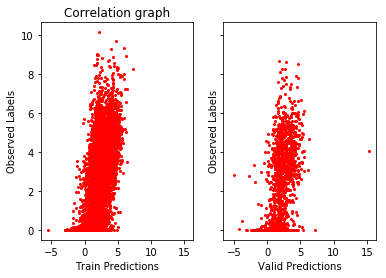

In [28]:
linearRegression = LinearRegression()
linearRegression.fit(x_train, np.arcsinh(y_train_regression_labels))
reweighted_predictions, _ = evaluate(linearRegression, x_train, y_train_regression_labels, x_valid, y_valid_regression_labels, 'weightedPromoters', 'weightedPromoters_Basset_LinearRegression')

# Distance + Basset

Let's try a different way to use distance

In [117]:
data = pd.read_csv("/mnt/lab_data2/kmualim/enh-gene-linking/datasets/embeddings/new_version/weightedPromoterEnhancerLinks/distance_links/EnhancerPredictionsAllPutative_DistanceLinks.txt", sep="\t")
data['distance'] = data['distance'].astype('int')

data_rename = data.rename(columns={'chr':0, 'start':1, 'end':2, 'TargetGene':3, 'dist':4})
distance_scores = data_rename[[0,1,2,3,4]]

In [124]:
data['dist_normalized'] = data['dist'] - min(data['dist'])/ (max(data['dist']) - min(data['dist']))

In [142]:
data['dist'] = 1/data['distance']
data['dist'] = data['dist'].replace(np.inf, 1.0)

In [145]:
data.to_csv("/mnt/lab_data2/kmualim/enh-gene-linking/datasets/embeddings/new_version/weightedPromoterEnhancerLinks/distance_links/EnhancerPredictionsAllPutative_NOINFDistanceLinks.txt", sep="\t", index=False)



In [143]:
max(data['dist'])

1.0

In [144]:
min(data['dist'])

1.9996188726428742e-07

In [127]:
# ranks E-G links by distance, could you rank links by reciprocal of linear distance 

data['dist_ranked'] = data['dist'].rank()
data['dist_ranked'].head()

0     9827844.5
1     7880747.0
2    11296706.5
3     3375897.5
4     2908785.5
Name: dist_ranked, dtype: float64

In [129]:
max(data['dist_ranked'])

13970973.0

In [14]:
from utils import *
distance_basset = pickle.load(open("/mnt/lab_data2/kmualim/enh-gene-linking/datasets/embeddings/new_version/weightedPromoterEnhancerLinks/distance_links/BassetDistanceModel.p", "rb"))
nonzero_distance_basset = remove_all_nonzero(distance_basset)

x_train_distance, x_valid_distance, x_test_distance, y_train_regression_labels_distance, y_valid_regression_labels_distance, y_test_regression_labels_distance,\
y_train_classif_labels_distance, y_valid_classif_labels_distance, y_test_classif_labels_distance, y_train_gene_labels_distance, y_valid_gene_labels_distance, y_test_gene_labels_distance = \
get_train_valid_split(gene_labels, nonzero_distance_basset, expression, classify=True)

Y Train:  14160
Y valid:  2655
Y test:  885
Y Train El 14160
Y Train El 2655
Y Train El 885
Y Train labels: 12017
Y valid labels: 2236
Y Test labels: 740
X Train labels: 12017
X valid labels: 2236
X test labels: 740
Y Train C: 12017
Y Valid C: 2236
Y Test C: 740
Y Train R: 12017
Y Valid R: 2236
Y Test R: 740


keeps getting "array must not contain infs or NaNs" error,  let's look into standardizing the array

Train Spearman R: SpearmanrResult(correlation=0.36433238097263165, pvalue=0.0)
Train Pearson R: (0.3444998584054064, 0.0)
Valid Spearman R: SpearmanrResult(correlation=0.1972343924707918, pvalue=1.2951839897413567e-27)
Valid Pearson R: (0.06279138840592104, 0.0005903302786829513)
Model Performance
MSError: 11.8291 


(array([1.4610691, 1.602335 , 1.3391132, ..., 2.194849 , 1.1593266,
        1.7882023], dtype=float32),
 array([1.2787724, 1.4974003, 1.2603474, ..., 1.6607914, 1.8085117,
        1.7118473], dtype=float32))

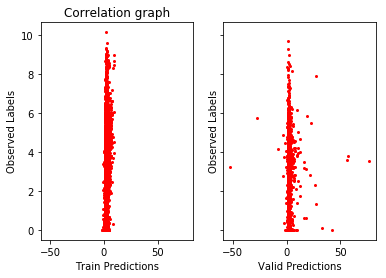

In [153]:
linreg = LinearRegression()
linreg.fit(x_train_distance, np.arcsinh(y_train_regression_labels_distance))
evaluate(linreg, x_train_distance, y_train_regression_labels_distance, x_valid_distance, y_valid_regression_labels_distance, 'constantPromoters', 'distanceWeighted_BassetEmbeddings')


This is how the distance model performs

Y Train:  11804
Y valid:  2213
Y test:  738
Y Train El 11804
Y Train El 2213
Y Train El 738
Y Train labels: 9926
Y valid labels: 1850
Y Test labels: 617
X Train labels: 9926
X valid labels: 1850
X test labels: 617
Y Train C: 9926
Y Valid C: 1850
Y Test C: 617
Y Train R: 9926
Y Valid R: 1850
Y Test R: 617
Train Spearman R: SpearmanrResult(correlation=0.6758874715771713, pvalue=0.0)
Train Pearson R: (0.6434967974884799, 0.0)
Valid Spearman R: SpearmanrResult(correlation=0.6048857911065103, pvalue=4.881526383838039e-185)
Valid Pearson R: (0.539075381905893, 5.734310231646284e-140)
Model Performance
MSError: 3.1101 


(array([4.283725 , 1.0129554, 1.7928364, ..., 1.3158991, 3.6582673,
        1.0274789], dtype=float32),
 array([4.1553144 , 1.4147446 , 3.7510254 , ..., 0.11849141, 0.64861035,
        0.9126961 ], dtype=float32))

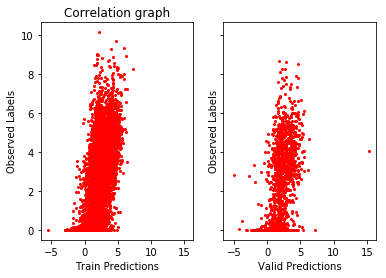

In [154]:
x_train_distance_nonzero, x_valid_distance_nonzero, x_test_distance_nonzero, y_train_regression_labels_distance_nonzero, y_valid_regression_labels_distance_nonzero, y_test_regression_labels_distance_nonzero,\
y_train_classif_labels_distance_nonzero, y_valid_classif_labels_distance_nonzero, y_test_classif_labels_distance_nonzero, y_train_gene_labels_distance_nonzero, y_valid_gene_labels_distance_nonzero, y_test_gene_labels_distance_nonzero = \
get_train_valid_split(gene_labels, nonzero_basset_model_regions, expression, classify=True)

linreg = LinearRegression()
linreg.fit(x_train_distance_nonzero, np.arcsinh(y_train_regression_labels_distance_nonzero))
evaluate(linreg, x_train_distance_nonzero, y_train_regression_labels_distance_nonzero, x_valid_distance_nonzero, y_valid_regression_labels_distance_nonzero, 'constantPromoters', 'distanceWeighted_NONZERO_BassetEmbeddings')

# random forest for distance + basset model

/users/kmualim/.conda/envs/jpt/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train Spearman R: SpearmanrResult(correlation=0.9216123495354851, pvalue=0.0)
Train Pearson R: (0.9441047403430716, 0.0)
Valid Spearman R: SpearmanrResult(correlation=0.5919148796578387, pvalue=1.613591210143697e-211)
Valid Pearson R: (0.5553649579810411, 3.794421616023424e-181)
Model Performance
MSError: 2.9074 


(array([4.91038321, 0.20543656, 3.38169692, ..., 1.80889382, 0.25855483,
        0.        ]),
 array([2.9089104 , 2.88250247, 3.17237555, ..., 2.48997579, 3.67941629,
        0.0059996 ]))

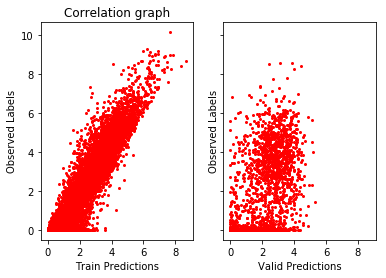

In [15]:
rfr = RandomForestRegressor()
rfr.fit(x_train_distance, np.arcsinh(y_train_regression_labels_distance))
evaluate(rfr, x_train_distance, y_train_regression_labels_distance, x_valid_distance, y_valid_regression_labels_distance, 'constantPromoters', 'distanceWeighted_BassetEmbeddings')


In [18]:
rf_random_dist = tune_random_forest(x_train_distance, y_train_regression_labels_distance, random_grid)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
/users/kmualim/.conda/envs/jpt/lib/python3.5/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=30)]: Done 102 tasks      | elapsed: 37.3min
[Parallel(n_jobs=30)]: Done 300 out of 300 | elapsed: 143.5min finished


In [31]:
# using basset the values are worst 
#outdir = "/mnt/lab_data2/kmualim/enh-gene-linking/datasets/embeddings/new_version/weightedPromoterEnhancerLinks/distance_links"
basset_constantpromoter = pickle.load(open('/mnt/lab_data2/kmualim/enh-gene-linking/datasets/embeddings/new_version/constant_promoter_weights/BassetConstantPromoterEmbeddings.p', "rb"))
nonzero_constantpromoter_basset = remove_all_nonzero(basset_constantpromoter)

x_train, x_valid, x_test, y_train_regression_labels, y_valid_regression_labels, y_test_regression_labels,\
y_train_classif_labels, y_valid_classif_labels, y_test_classif_labels, y_train_gene_labels, y_valid_gene_labels, y_test_gene_labels = \
get_train_valid_split(gene_labels, nonzero_constantpromoter_basset , expression, classify=True)


Y Train:  12690
Y valid:  2379
Y test:  794
Y Train El 12690
Y Train El 2379
Y Train El 794
Y Train labels: 10684
Y valid labels: 2021
Y Test labels: 652
X Train labels: 10684
X valid labels: 2021
X test labels: 652
Y Train C: 10684
Y Valid C: 2021
Y Test C: 652
Y Train R: 10684
Y Valid R: 2021
Y Test R: 652


Train Spearman R: SpearmanrResult(correlation=0.3840556592205495, pvalue=0.0)
Train Pearson R: (0.3799607076118965, 0.0)
Valid Spearman R: SpearmanrResult(correlation=0.14344830462227, pvalue=9.273977019506863e-11)
Valid Pearson R: (0.10730913533515668, 1.3306409649075845e-06)


FileNotFoundError: [Errno 2] No such file or directory: 'constantPromoters/L_constantPromoters_Basset_LinearRegression.pdf'

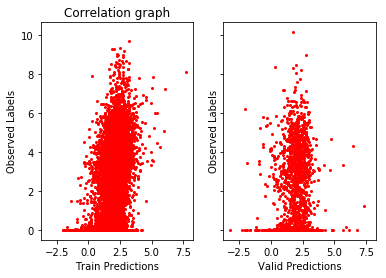

In [8]:
linearRegression = LinearRegression()
linearRegression.fit(x_train, np.arcsinh(y_train_regression_labels))
reweighted_predictions, _ = evaluate(linearRegression, x_train, y_train_regression_labels, x_valid, y_valid_regression_labels, 'constantPromoters', 'constantPromoters_Basset_LinearRegression')

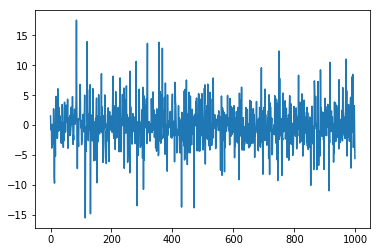

In [17]:
import matplotlib.pyplot as plt

weights = np.array(linearRegression.coef_) 
length_ = np.arange(0, len(weights))
plt.plot(length_, weights)

Spearman R SpearmanrResult(correlation=0.9066149387314352, pvalue=0.0)
Pearson R (0.9754107795170732, 0.0)
Model Performance
Average Error: 0.5325 degrees.


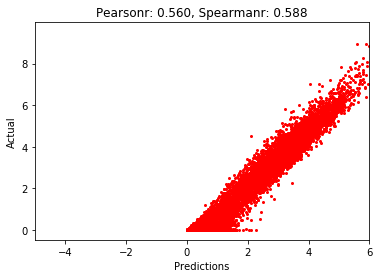

In [125]:
# basset
rand_forest = RandomForestRegressor()
rand_forest.fit(x_train, np.arcsinh(y_train_regression_labels))
rand_forest_train_preds , _ = evaluate(rand_forest, x_train, y_train_regression_labels)

Spearman R SpearmanrResult(correlation=0.49820541069345875, pvalue=8.737469788883092e-132)
Pearson R (0.48319025489551454, 5.92428712953295e-123)
Model Performance
Average Error: 1.4323 degrees.


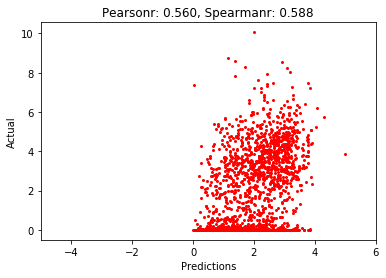

In [126]:
rand_forest_train_preds , _ = evaluate(rand_forest, x_valid, y_valid_regression_labels)

# hyperparameter tuning

In [17]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators':n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

def tune_random_forest(x_train, y_train_regression_labels, random_grid):
    rf = RandomForestRegressor()
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 30)
    rf_random.fit(x_train, np.arcsinh(y_train_regression_labels))
    return rf_random

{'bootstrap': [True, False], 'n_estimators': [50, 77, 105, 133, 161, 188, 216, 244, 272, 300], 'min_samples_split': [2, 5, 10], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_leaf': [1, 2, 4], 'max_features': ['auto', 'sqrt']}


In [ ]:
rf_random = tune_random_forest(x_train, y_train_regression_labels, random_grid)

basset random forest hyperparameter tuning

In [13]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 188}

Train Spearman R: SpearmanrResult(correlation=0.9111113633125684, pvalue=0.0)
Train Pearson R: (0.9442997917705206, 0.0)
Valid Spearman R: SpearmanrResult(correlation=0.5232129931192874, pvalue=7.551605922862914e-143)
Valid Pearson R: (0.49707454879654717, 5.727714192856981e-127)
Model Performance
MSError: 3.2871 


(array([0.73746842, 2.91781176, 1.80629728, ..., 3.41934086, 1.52333928,
        1.74947375]),
 array([3.03108653, 2.61673687, 0.55225759, ..., 2.80167122, 1.49232816,
        1.27754285]))

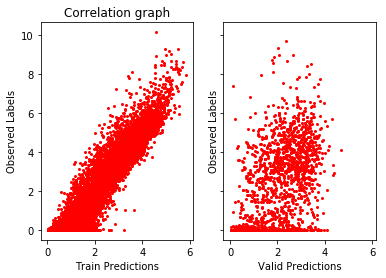

In [15]:
evaluate(rf_random ,x_train, y_train_regression_labels, x_valid, y_valid_regression_labels, 'Basset_nonZero_constantPromoters', 'Basset_nonZero_constantPromoters_1')

In [22]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np
# Number of trees in random forest
n_estimators = [100, 180, 190, 200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [40, 60, 70, 80]
# Minimum number of samples required to split a node
min_samples_split = [9, 10, 11, 12]
# Minimum number of samples required at each leaf node
min_samples_leaf = [3, 4, 5, 6, 7 ]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators':n_estimators,
            'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
               }
print(random_grid)

def tune_grid_rf(x_train, y_train_regression_labels, random_grid):
    rf = RandomForestRegressor(bootstrap=True, max_features='auto')
    rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 3, verbose=2, n_jobs = 10)
    rf_random.fit(x_train, np.arcsinh(y_train_regression_labels))
    return rf_random

rf_random = tune_grid_rf(x_train, y_train_regression_labels, random_grid)


{'max_depth': [40, 60, 70, 80], 'min_samples_split': [9, 10, 11, 12], 'n_estimators': [100, 180, 190, 200], 'min_samples_leaf': [3, 4, 5, 6, 7]}
Fitting 3 folds for each of 320 candidates, totalling 960 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 42.9min
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed: 246.3min
/users/kmualim/.conda/envs/jpt/lib/python3.5/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=10)]: Done 345 tasks      | elapsed: 539.4min
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed: 800.2min
[Parallel(n_jobs=10)]: Done 960 out of 960 | elapsed: 1078.4min finished


In [23]:
rf_random.best_params_

{'max_depth': 80,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 200}

Train Spearman R: SpearmanrResult(correlation=0.9096514994368153, pvalue=0.0)
Train Pearson R: (0.9415130186517224, 0.0)
Valid Spearman R: SpearmanrResult(correlation=0.5372076935765384, pvalue=1.7078713621240778e-151)
Valid Pearson R: (0.5267025062970205, 1.1892139310586626e-144)


FileNotFoundError: [Errno 2] No such file or directory: 'rf_tuning/G_basset_rf_tuning.pdf'

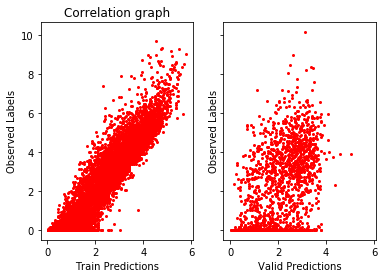

In [26]:
evaluate(rf_random, x_train, y_train_regression_labels, x_valid, y_valid_regression_labels, 'rf_tuning', 'basset_rf_tuning')

Spearman R SpearmanrResult(correlation=0.9097745360190472, pvalue=0.0)
Pearson R (0.9310411806015201, 0.0)
Model Performance
Average Error: 0.8795 degrees.


(array([3.51845533, 2.9020159 , 4.12415362, ..., 1.88406665, 3.78655173,
        0.3001938 ]),
 array([1.11384164, 1.52051154, 2.00713927, ..., 1.88406665, 1.73970399,
        0.3001938 ]))

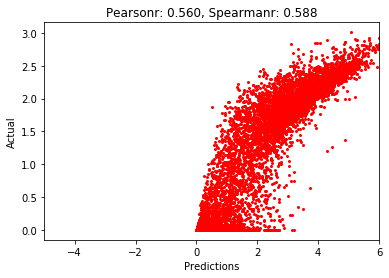

In [50]:
# How did we get these values!  -- these  are probably pro-seq values!!! 
evaluate(rf_random, x_train, np.arcsinh(y_train_regression_labels))

Spearman R SpearmanrResult(correlation=0.7169014821037345, pvalue=1.39737140430019e-295)
Pearson R (0.725068352950889, 1.479777691927482e-305)
Model Performance
Average Error: 0.9892 degrees.


(array([0.20770328, 3.48530047, 2.26736117, ..., 0.86071969, 0.195734  ,
        0.3980108 ]),
 array([0.17771227, 1.79293172, 0.03066252, ..., 0.04521369, 0.195734  ,
        0.3980108 ]))

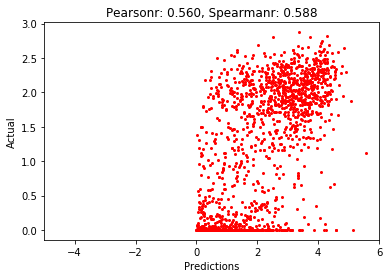

In [51]:
evaluate(rf_random, x_valid, np.arcsinh(y_valid_regression_labels))

This achieves same performance as these parameters: 
{'max_depth': 80,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 200}

Train Spearman R: SpearmanrResult(correlation=0.9089394711507248, pvalue=0.0)
Train Pearson R: (0.9417385159636315, 0.0)
Valid Spearman R: SpearmanrResult(correlation=0.5144126357583513, pvalue=2.3975390813987077e-137)
Valid Pearson R: (0.4890387091867118, 2.3378396902127146e-122)
Model Performance
MSError: 3.3195 


(array([0.66590974, 2.7464976 , 1.70703609, ..., 3.08557925, 1.55416125,
        2.04463751]),
 array([2.94184663, 2.75619928, 0.54022152, ..., 3.22293277, 1.25092023,
        1.22717859]))

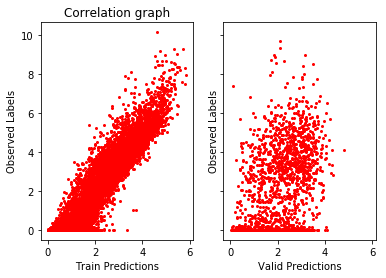

In [9]:
rf = RandomForestRegressor(n_estimators=100, bootstrap=True, max_depth=70, max_features='auto', min_samples_leaf=4, min_samples_split=10)
rf.fit(x_train, np.arcsinh(y_train_regression_labels))
!mkdir Basset_nonZero_constantPromoters
evaluate(rf,x_train, y_train_regression_labels, x_valid, y_valid_regression_labels, 'Basset_nonZero_constantPromoters', 'Basset_nonZero_constantPromoters')

n_estimators = 235

Spearman R SpearmanrResult(correlation=0.9265595719860245, pvalue=0.0)
Pearson R (0.951145272334269, 0.0)
Model Performance
Average Error: 0.8877 degrees.


(array([4.5724883 , 2.00794429, 3.36905382, ..., 1.5446456 , 3.26954569,
        1.69043323]),
 array([2.16787461, 0.51448649, 1.39636203, ..., 1.5446456 , 1.22269795,
        1.69043323]))

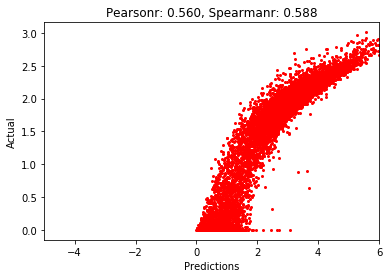

In [28]:
evaluate(rf_random, x_train, np.arcsinh(y_train_regression_labels))

Spearman R SpearmanrResult(correlation=0.5316953769048056, pvalue=3.103365408112088e-148)
Pearson R (0.5311947808920523, 6.57864344082543e-148)
Model Performance
Average Error: 1.0919 degrees.


(array([1.60737284, 1.71753098, 3.07164598, ..., 3.39749875, 1.83152424,
        2.59458761]),
 array([1.57738183, 0.44032433, 0.93933722, ..., 2.62412585, 1.83152424,
        1.12545257]))

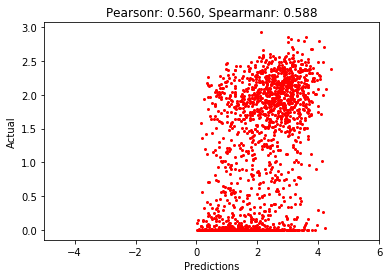

In [25]:
evaluate(rf_random, x_valid, np.arcsinh(y_valid_regression_labels))

Spearman R SpearmanrResult(correlation=0.5581648508810078, pvalue=7.876627081545965e-255)
Pearson R (0.5117070063359735, 1.2202752670180543e-207)
Model Performance
MSError: 3.0706 


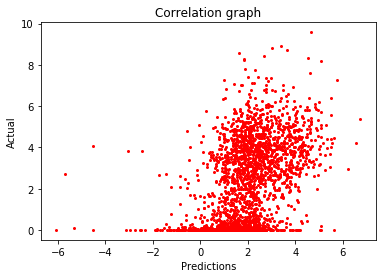

In [51]:
reweighted_valid_predictions, _ = evaluate(linearRegression, x_valid, y_valid_regression_labels)

In [52]:
basset_preds = pd.DataFrame()
basset_preds['train_predictions'] = reweighted_predictions 
basset_preds['train_labels'] = np.arcsinh(y_train_regression_labels)
valid_basset_predictions = pd.DataFrame()
valid_basset_predictions['valid_predictions'] = reweighted_valid_predictions
valid_basset_predictions['valid_labels'] = np.arcsinh(y_valid_regression_labels)


<a id='bassetdensity'></a>
#### density plots for basset

ZeroDivisionError: division by zero

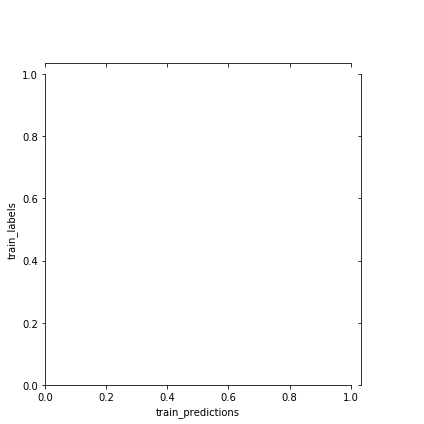

In [53]:
sns.jointplot('train_predictions', 'train_labels', data=basset_preds, kind="hex")

In [54]:
b_non = np.where(np.arcsinh(y_train_regression_labels)==0)
print("Number of genes where expression==0:", len(b_non[0]))
print("Number of total genes:", len(y_train_regression_labels))

Number of genes where expression==0: 5538
Number of total genes: 16522


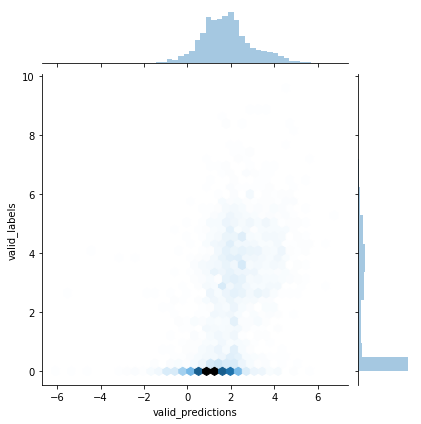

In [267]:
sns.jointplot('valid_predictions', 'valid_labels', data=valid_basset_predictions, kind="hex")

In [55]:
b_non_v = np.where(np.arcsinh(y_valid_regression_labels)==0)
print("Number of genes where expression==0:", len(b_non_v[0]))
print("Number of total genes:", len(y_valid_regression_labels))

Number of genes where expression==0: 1039
Number of total genes: 3117


In [147]:
np.savez("reweighted_train_predictions_basset.npz", reweighted_predictions)
np.savez("reweighted_valid_predictions_basset.npz", reweighted_valid_predictions)

In [29]:
len(y_valid_regression_labels)

3121

# Questions to ask: 
1. What caused the slight increase in performance when we used promoter activity instead of weights assigned via 1-(sum of enhancer weights) 
From just mere observations, it seems like now a lot of the embeddings aren't weighted at 0, which really helps push predictions of promoters  <br> 

2. Differences in terms of which points improved or did predictions overall improve? 

Comparison of originally weighted promoters + Basset embeddings, where promoters were weighted by 1-(sum of enhancer weights)

In [2]:
linreg = joblib.load("/mnt/lab_data2/kmualim/Jamboree_data/models/abc_all/test_models/ABC.Score_linreg.joblib")

/users/kmualim/.conda/envs/jpt/lib/python3.5/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LinearRegression from version 0.21.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [4]:
x_train_reg = np.load("/mnt/lab_data2/kmualim/Jamboree_data/datasets/train_valid_test_all/x_train_reg_all.npz")['arr_0']
x_valid_reg = np.load("/mnt/lab_data2/kmualim/Jamboree_data/datasets/train_valid_test_all/x_valid_reg_all.npz")['arr_0']
y_train_reg = np.load("/mnt/lab_data2/kmualim/Jamboree_data/datasets/train_valid_test_all/y_train_reg_all.npz")['arr_0']
y_valid_reg = np.load("/mnt/lab_data2/kmualim/Jamboree_data/datasets/train_valid_test_all/y_valid_reg_all.npz")['arr_0']

Spearman R SpearmanrResult(correlation=0.5191002177935998, pvalue=4.9934391408077526e-213)
Pearson R (0.4278093144464053, 7.031902738312884e-138)
Model Performance
Average Error: 1.4952 degrees.


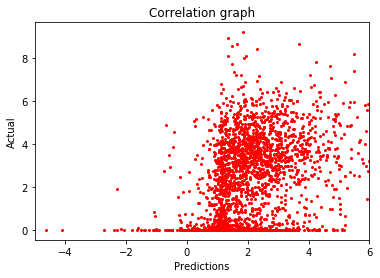

In [38]:
predictions, _ = evaluate(linreg, x_valid_reg[:3093], y_valid_reg[:3093])

seems like the promoter weights just prevent points from going out of the box 

SpearmanrResult(correlation=0.04221500985842835, pvalue=0.018880873142390068)
(0.024048608887876584, 0.1811867253307507)


Text(0, 0.5, 'Reweighted Predictions')

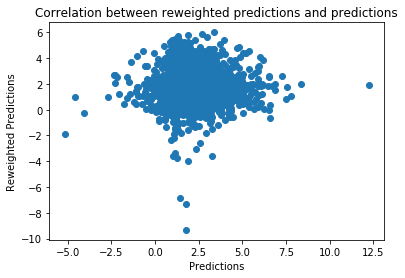

In [40]:
plt.scatter(predictions, reweighted_predictions)
print(scipy.stats.spearmanr(predictions, reweighted_predictions))
print(scipy.stats.pearsonr(predictions, reweighted_predictions))
plt.title("Correlation between reweighted predictions and predictions")
plt.xlabel("Predictions")
plt.ylabel("Reweighted Predictions")

# distance + deepsea

In [4]:
data = pickle.load(open("/mnt/lab_data2/kmualim/enh-gene-linking/datasets/embeddings/new_version/weightedPromoterEnhancerLinks/distance_links/DistanceWeightedRANDOMSHUFFLEDDeepseaembeddings_03112020.p", "rb"))
nonzero_dist = remove_all_nonzero(data)

x_train_deepsea, x_valid_deepsea, x_test_deepsea, y_train_regression_labels_deepsea, y_valid_regression_labels_deepsea, y_test_regression_labels,\
y_train_classif_labels_deepsea, y_valid_classif_labels_deepsea, y_test_classif_labels_deepsea, y_train_gene_labels_deepsea, y_valid_gene_labels_deepsea, y_test_gene_labels_deepsea = \
get_train_valid_split(gene_labels, nonzero_dist, expression, classify=True)

NameError: name 'remove_all_nonzero' is not defined